In [ ]:
!pip install xgboost
!pip install catboost
!pip install seaborn
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import uniform, randint
import optuna
import os
from pathlib import Path

In [ ]:
# --- Загрузка данных ---
file_url_pca = 'https://drive.google.com/uc?export=download&id=1SuUhkpfj-3uJQnxwmUCyDUogfa2TixTe'
file_url_manual = 'https://drive.google.com/uc?export=download&id=1p8VYp23oOylSFrfJztQVheNLop-bX40o'

# Загрузка данных
df_pca = pd.read_csv(file_url_pca, encoding='utf-8')
df_manual = pd.read_csv(file_url_manual, encoding='utf-8')

# Вывод первых строк для проверки
print("PCA Data:")
print(df_pca.head())
print("\nManual Data:")
print(df_manual.head())

PCA Data:
   IC50, mM  CC50, mM        SI  MaxEStateIndex  MinAbsEStateIndex  \
0  1.979535  5.173221  3.371597        5.094096           0.327305   
1  0.572014  1.856738  2.079442        3.961417           0.427793   
2  5.415250  5.088474  0.542324        2.627117           0.433878   
3  0.995333  4.690023  4.162553        5.097360           0.329737   
4  4.683348  4.943576  0.832909        5.150510           0.239392   

   MinEStateIndex       qed        SPS    MolWt  HeavyAtomMolWt  ...  \
0        0.327305  0.417362  42.928571  384.652         340.300  ...   
1        0.427793  0.462473  45.214286  388.684         340.300  ...   
2        0.433878  0.260923  42.187500  446.808         388.344  ...   
3        0.329737  0.377846  41.862069  398.679         352.311  ...   
4        0.239392  0.429038  36.514286  466.713         424.377  ...   

   fr_tetrazole  fr_thiazole  fr_thiophene  fr_unbrch_alkane  fr_urea  \
0             0            0             0          1.386294   

In [ ]:
# Целевые переменные
TARGETS = ['IC50, mM', 'CC50, mM', 'SI']

In [ ]:
# --- Вспомогательная функция для расчета метрик ---
def calculate_metrics(y_true, y_pred):
    """Вычисляет RMSE, MAE и R2."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

# --- Функции для каждого метода оптимизации ---

def run_randomized_search(model_instance, param_distributions, X_train_scaled, y_train, n_iter_search=20):
    """Выполняет RandomizedSearchCV для подбора гиперпараметров."""
    if not param_distributions: # Для моделей без параметров, например, LinearRegression
        model_instance.fit(X_train_scaled, y_train)
        return model_instance, {}
    random_search = RandomizedSearchCV(model_instance, param_distributions, n_iter=n_iter_search,
                                       cv=5, scoring='neg_root_mean_squared_error',
                                       n_jobs=-1, verbose=0, random_state=42)
    random_search.fit(X_train_scaled, y_train)
    return random_search.best_estimator_, random_search.best_params_

def run_grid_search(model_instance, param_grid, X_train_scaled, y_train):
    """Выполняет GridSearchCV для подбора гиперпараметров."""
    if not param_grid: # Для моделей без параметров
        model_instance.fit(X_train_scaled, y_train)
        return model_instance, {}
    grid_search = GridSearchCV(model_instance, param_grid, cv=3, scoring='neg_root_mean_squared_error',
                               n_jobs=-1, verbose=0)
    grid_search.fit(X_train_scaled, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

def run_optuna_search(model_class, optuna_search_space, X_train_scaled, y_train, n_trials=20):
    """Выполняет оптимизацию гиперпараметров с помощью Optuna."""
    def objective(trial):
        params = optuna_search_space(trial) # Получаем параметры из триала Optuna
        model = model_class(**params) # Убираем random_state здесь, если он уже в params

        from sklearn.model_selection import KFold
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        for train_idx, val_idx in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            if isinstance(model, CatBoostRegressor):
                # CatBoost может иметь проблемы с именами столбцов/индексами, если они не простые
                # Создаем Pool для CatBoost, если данные являются Pandas Series/DataFrame
                try:
                    from catboost import Pool
                    train_pool = Pool(X_train_fold, y_train_fold)
                    val_pool = Pool(X_val_fold, y_val_fold)
                    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=10, verbose=False)
                except Exception as e:
                    print(f"Ошибка при обучении CatBoost в Optuna: {e}")
                    # Возвращаем очень большое значение, чтобы Optuna избегала этих параметров
                    return float('inf')
            else:
                model.fit(X_train_fold, y_train_fold)

            y_val_pred = model.predict(X_val_fold)
            rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
            cv_scores.append(rmse_fold)
        return np.mean(cv_scores)

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    # show_progress_bar=False, чтобы не засорять вывод в Colab
    # Добавляем (Exception,) в catch для более общего перехвата ошибок внутри objective
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False, catch=(ValueError, Exception))

    best_params = study.best_params
    best_model_instance = model_class(**best_params) # Убираем random_state здесь, если он уже в params

    if isinstance(best_model_instance, CatBoostRegressor):
        try:
            from catboost import Pool
            train_pool_final = Pool(X_train_scaled, y_train)
            best_model_instance.fit(train_pool_final, verbose=False)
        except Exception as e:
            print(f"Ошибка при окончательном обучении CatBoost: {e}")
            return None, {} # Возвращаем None, если окончательное обучение не удалось
    else:
        best_model_instance.fit(X_train_scaled, y_train)

    return best_model_instance, best_params


# --- Общая функция для оценки моделей с различными оптимизаторами ---
def evaluate_model_with_optimizer(model_name, model_class, params_config, X, y, target_name, optimizer_type):
    """Оценивает производительность модели, используя указанный метод оптимизации."""

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    best_model = None
    best_params = {}

    if optimizer_type == 'RandomizedSearchCV':
        param_distributions = params_config.get('random_dist', {})
        # Для LinearRegression, Ridge, Lasso, у которых random_dist может быть пустым
        # если нет настраиваемых параметров, или мы хотим использовать более простую модель
        if model_name in ["LinearRegression"] and not param_distributions:
            model_instance = model_class()
            model_instance.fit(X_train_scaled, y_train)
            best_model, best_params = model_instance, {}
        else:
            best_model, best_params = run_randomized_search(model_class(), param_distributions, X_train_scaled, y_train, n_iter_search=20)

    elif optimizer_type == 'GridSearchCV':
        param_grid = params_config.get('grid_params', {})
        if not param_grid:
            # Для моделей без сетки, просто обучаем без подбора
            model_instance = model_class()
            model_instance.fit(X_train_scaled, y_train)
            best_model, best_params = model_instance, {}
        else:
            best_model, best_params = run_grid_search(model_class(), param_grid, X_train_scaled, y_train)

    elif optimizer_type == 'Optuna':
        optuna_space = params_config.get('optuna_space')
        if optuna_space is None:
            # Для моделей без пространства Optuna, просто обучаем без подбора
            model_instance = model_class()
            model_instance.fit(X_train_scaled, y_train)
            best_model, best_params = model_instance, {}
        else:
            best_model, best_params = run_optuna_search(model_class, optuna_space, X_train_scaled, y_train, n_trials=20)

    else:
        raise ValueError(f"Неизвестный тип оптимизатора: {optimizer_type}")

    if best_model is None: # Если обучение CatBoost в Optuna завершилось ошибкой
        return None

    y_pred = best_model.predict(X_test_scaled)
    rmse, mae, r2 = calculate_metrics(y_test, y_pred)

    return {
        'model': model_name,
        'optimizer': optimizer_type,
        'target': target_name,
        'best_params': best_params,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }


# --- Определение моделей и их гиперпараметров для разных оптимизаторов ---
# Обновляем `suggest_loguniform` на `suggest_float(..., log=True)`
# Увеличиваем `max_iter` для MLPRegressor

models_config = {
    "LinearRegression": {
        "class": LinearRegression,
        "random_dist": {},
        "grid_params": {}, # Нет настраиваемых параметров для базовой LinearRegression
        "optuna_space": None
    },
    "Ridge": {
        "class": Ridge,
        "random_dist": {'alpha': uniform(loc=0.1, scale=20)},
        "grid_params": {'alpha': [0.1, 1.0, 10.0]}, # Ограниченная сетка для GridSearchCV
        "optuna_space": lambda trial: {'alpha': trial.suggest_float('alpha', 0.1, 20, log=True)}
    },
    "Lasso": {
        "class": Lasso,
        "random_dist": {'alpha': uniform(loc=0.001, scale=1.0)},
        "grid_params": {'alpha': [0.001, 0.01, 0.1]}, # Ограниченная сетка для GridSearchCV
        "optuna_space": lambda trial: {'alpha': trial.suggest_float('alpha', 0.001, 1.0, log=True), 'max_iter': 2000}
    },
    "RandomForestRegressor": {
        "class": RandomForestRegressor,
        "random_dist": {
            'n_estimators': randint(50, 200),
            'max_depth': [5, 10, None],
            'min_samples_split': randint(2, 8)
        },
        "grid_params": { # Очень ограниченная сетка для GridSearchCV
            'n_estimators': [100, 150],
            'max_depth': [5, 10],
        },
        "optuna_space": lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_categorical('max_depth', [5, 10, 15, None]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
            'random_state': 42 # Добавляем random_state для воспроизводимости
        }
    },
    "XGBRegressor": {
        "class": XGBRegressor,
        "random_dist": {
            'n_estimators': randint(50, 200),
            'learning_rate': uniform(0.01, 0.15),
            'max_depth': randint(3, 8),
            'subsample': uniform(0.7, 0.3)
        },
        "grid_params": { # Ограниченная сетка для GridSearchCV
            'n_estimators': [100, 150],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        },
        "optuna_space": lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0), # uniform
            'eval_metric': 'rmse',
            'n_jobs': -1,
            'random_state': 42 # Добавляем random_state
        }
    },
    "CatBoostRegressor": {
        "class": CatBoostRegressor,
        "random_dist": {
            'iterations': randint(50, 200),
            'learning_rate': uniform(0.01, 0.15),
            'depth': randint(3, 8),
            'l2_leaf_reg': uniform(1, 7)
        },
        "grid_params": { # Ограниченная сетка для GridSearchCV
            'iterations': [100, 150],
            'learning_rate': [0.05, 0.1],
            'depth': [3, 5]
        },
        "optuna_space": lambda trial: {
            'iterations': trial.suggest_int('iterations', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            'depth': trial.suggest_int('depth', 3, 8),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
            'verbose': False,
            'random_seed': 42,
            'thread_count': -1
        }
    },
    "MLPRegressor": {
        "class": MLPRegressor,
        "random_dist": {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'alpha': uniform(0.0001, 0.005),
            'learning_rate_init': uniform(0.0001, 0.005)
        },
        "grid_params": {
            'hidden_layer_sizes': [(50,), (100,)],
            'alpha': [0.0001, 0.001]
        },
        "optuna_space": lambda trial: {
            'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50)]),
            'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
            'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
            'max_iter': 2000, # Увеличиваем max_iter
            'random_state': 42, # Добавляем random_state
            'solver': 'adam' # Часто 'adam' сходится лучше
        }
    }
}

In [ ]:
# --- Основной цикл оценки с тремя методами оптимизации ---
all_results = []
optimizers = ['RandomizedSearchCV', 'GridSearchCV', 'Optuna']

X_pca = df_pca.drop(columns=TARGETS)
X_manual = df_manual.drop(columns=TARGETS)

print("Начинаем процесс обучения и оценки моделей с различными методами оптимизации (50 итераций)...")

# Внешний прогресс-бар для целевых переменных
for target in tqdm(TARGETS, desc="Прогнозирование целевых переменных"):
    for data_source_name, X_data, df_data in [("PCA Aggregated", X_pca, df_pca), ("Manual Aggregated", X_manual, df_manual)]:
        # Внутренний прогресс-бар для оптимизаторов и моделей
        num_models_to_run = 0
        for model_name, config in models_config.items():
            for optimizer_type in optimizers:
                # Упрощенная логика для подсчета моделей
                if optimizer_type == 'RandomizedSearchCV' and not config['random_dist'] and model_name not in ["LinearRegression"]:
                     continue # Пропускаем, если random_dist пуст и это не LinearRegression
                if optimizer_type == 'GridSearchCV' and not config['grid_params'] and model_name not in ["LinearRegression"]:
                     continue # Пропускаем, если grid_params пуст и это не LinearRegression
                if optimizer_type == 'Optuna' and config['optuna_space'] is None and model_name not in ["LinearRegression"]:
                     continue # Пропускаем, если optuna_space None и это не LinearRegression
                num_models_to_run += 1

        with tqdm(total=num_models_to_run, desc=f"Оптимизация для {target} ({data_source_name})", leave=False) as pbar_inner:
            for optimizer_type in optimizers:
                for model_name, config in models_config.items():
                    # Пропускаем неподходящие комбинации модель-оптимизатор, чтобы избежать ошибок и не тратить время
                    if optimizer_type == 'RandomizedSearchCV' and not config['random_dist'] and model_name != "LinearRegression":
                        pbar_inner.update(1)
                        continue
                    if optimizer_type == 'GridSearchCV' and not config['grid_params'] and model_name != "LinearRegression":
                        pbar_inner.update(1)
                        continue
                    if optimizer_type == 'Optuna' and config['optuna_space'] is None and model_name != "LinearRegression":
                        pbar_inner.update(1)
                        continue

                    model_class = config["class"]
                    params_config = config

                    # Обновляем описание для внутреннего прогресс-бара
                    pbar_inner.set_description(f"Оптимизация для {target} ({data_source_name}) - {model_name} ({optimizer_type})")

                    result = evaluate_model_with_optimizer(model_name, model_class, params_config,
                                                           X_data, df_data[target], target, optimizer_type)
                    if result:
                        result['data_source'] = data_source_name
                        all_results.append(result)
                    pbar_inner.update(1) # Обновляем после каждого запуска модели

Начинаем процесс обучения и оценки моделей с различными методами оптимизации (50 итераций)...


Прогнозирование целевых переменных:   0%|          | 0/3 [00:00<?, ?it/s]

Оптимизация для IC50, mM (PCA Aggregated):   0%|          | 0/21 [00:00<?, ?it/s]

0:	learn: 1.7866305	total: 65.5ms	remaining: 10.4s
1:	learn: 1.7446373	total: 83ms	remaining: 6.56s
2:	learn: 1.7027287	total: 97.4ms	remaining: 5.1s
3:	learn: 1.6721156	total: 111ms	remaining: 4.35s
4:	learn: 1.6495057	total: 125ms	remaining: 3.89s
5:	learn: 1.6171118	total: 139ms	remaining: 3.56s
6:	learn: 1.5894085	total: 153ms	remaining: 3.35s
7:	learn: 1.5691177	total: 167ms	remaining: 3.18s
8:	learn: 1.5489617	total: 181ms	remaining: 3.04s
9:	learn: 1.5312279	total: 195ms	remaining: 2.93s
10:	learn: 1.5119351	total: 209ms	remaining: 2.83s
11:	learn: 1.4921847	total: 222ms	remaining: 2.74s
12:	learn: 1.4744824	total: 236ms	remaining: 2.67s
13:	learn: 1.4582804	total: 250ms	remaining: 2.61s
14:	learn: 1.4395126	total: 264ms	remaining: 2.55s
15:	learn: 1.4304890	total: 282ms	remaining: 2.54s
16:	learn: 1.4204154	total: 297ms	remaining: 2.5s
17:	learn: 1.4047926	total: 311ms	remaining: 2.45s
18:	learn: 1.3936264	total: 325ms	remaining: 2.41s
19:	learn: 1.3831173	total: 339ms	remainin

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 1.7880320	total: 10.2ms	remaining: 1.51s
1:	learn: 1.7509835	total: 20.1ms	remaining: 1.49s
2:	learn: 1.7108329	total: 28.5ms	remaining: 1.4s
3:	learn: 1.6746742	total: 37.2ms	remaining: 1.36s
4:	learn: 1.6452260	total: 45.9ms	remaining: 1.33s
5:	learn: 1.6237939	total: 55.1ms	remaining: 1.32s
6:	learn: 1.5970529	total: 66.7ms	remaining: 1.36s
7:	learn: 1.5733934	total: 75.3ms	remaining: 1.34s
8:	learn: 1.5504154	total: 83.8ms	remaining: 1.31s
9:	learn: 1.5363445	total: 92.4ms	remaining: 1.29s
10:	learn: 1.5147344	total: 101ms	remaining: 1.28s
11:	learn: 1.4949890	total: 109ms	remaining: 1.26s
12:	learn: 1.4785536	total: 118ms	remaining: 1.24s
13:	learn: 1.4662350	total: 126ms	remaining: 1.23s
14:	learn: 1.4535220	total: 135ms	remaining: 1.21s
15:	learn: 1.4417983	total: 145ms	remaining: 1.21s
16:	learn: 1.4291062	total: 153ms	remaining: 1.2s
17:	learn: 1.4169542	total: 162ms	remaining: 1.19s
18:	learn: 1.4042377	total: 170ms	remaining: 1.17s
19:	learn: 1.3958856	total: 179ms

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-06-14 03:58:16,634] A new study created in memory with name: no-name-3746b753-e0b8-459a-af0d-bbc4c855d000
[I 2025-06-14 03:58:16,703] Trial 0 finished with value: 1.5927875453227045 and parameters: {'alpha': 0.7274917088027808}. Best is trial 0 with value: 1.5927875453227045.
[I 2025-06-14 03:58:16,829] Trial 1 finished with value: 1.524498254339046 and parameters: {'alpha': 15.40359659501924}. Best is trial 1 with value: 1.524498254339046.
[I 2025-06-14 03:58:17,129] Trial 2 finished with value: 1.5533094658936872 and parameters: {'alpha': 4.83437145318464}. Best is trial 1 with value: 1.524498254339046.
[I 2025-06-14 03:58:17,451] Trial 3 finished with value: 1.570595202852958 and parameters: {'alpha': 2.385234757844707}. Best is trial 1 with value: 1

Оптимизация для IC50, mM (Manual Aggregated):   0%|          | 0/21 [00:00<?, ?it/s]

0:	learn: 1.7795627	total: 22.3ms	remaining: 3.54s
1:	learn: 1.7379810	total: 38.1ms	remaining: 3.01s
2:	learn: 1.7006906	total: 59.4ms	remaining: 3.11s
3:	learn: 1.6608030	total: 75.2ms	remaining: 2.93s
4:	learn: 1.6290333	total: 91.2ms	remaining: 2.83s
5:	learn: 1.6080320	total: 107ms	remaining: 2.74s
6:	learn: 1.5781203	total: 123ms	remaining: 2.69s
7:	learn: 1.5568849	total: 139ms	remaining: 2.64s
8:	learn: 1.5373702	total: 155ms	remaining: 2.6s
9:	learn: 1.5183704	total: 174ms	remaining: 2.61s
10:	learn: 1.4980391	total: 191ms	remaining: 2.58s
11:	learn: 1.4794700	total: 210ms	remaining: 2.59s
12:	learn: 1.4600003	total: 229ms	remaining: 2.59s
13:	learn: 1.4449144	total: 248ms	remaining: 2.59s
14:	learn: 1.4302254	total: 264ms	remaining: 2.56s
15:	learn: 1.4194430	total: 280ms	remaining: 2.52s
16:	learn: 1.4031323	total: 296ms	remaining: 2.49s
17:	learn: 1.3914153	total: 312ms	remaining: 2.46s
18:	learn: 1.3795628	total: 328ms	remaining: 2.43s
19:	learn: 1.3698678	total: 344ms	rem

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 1.7785318	total: 12ms	remaining: 1.79s
1:	learn: 1.7356164	total: 21.7ms	remaining: 1.6s
2:	learn: 1.6976445	total: 31.4ms	remaining: 1.54s
3:	learn: 1.6659139	total: 40.7ms	remaining: 1.49s
4:	learn: 1.6303139	total: 50.4ms	remaining: 1.46s
5:	learn: 1.6062532	total: 61.4ms	remaining: 1.47s
6:	learn: 1.5796019	total: 75.9ms	remaining: 1.55s
7:	learn: 1.5570258	total: 99.6ms	remaining: 1.77s
8:	learn: 1.5373276	total: 110ms	remaining: 1.72s
9:	learn: 1.5197518	total: 120ms	remaining: 1.68s
10:	learn: 1.5006737	total: 130ms	remaining: 1.64s
11:	learn: 1.4806103	total: 140ms	remaining: 1.61s
12:	learn: 1.4668199	total: 150ms	remaining: 1.58s
13:	learn: 1.4567681	total: 160ms	remaining: 1.55s
14:	learn: 1.4415641	total: 170ms	remaining: 1.53s
15:	learn: 1.4265456	total: 179ms	remaining: 1.5s
16:	learn: 1.4153144	total: 189ms	remaining: 1.48s
17:	learn: 1.4043437	total: 199ms	remaining: 1.46s
18:	learn: 1.3944692	total: 208ms	remaining: 1.44s
19:	learn: 1.3870405	total: 222ms	rem

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-06-14 04:26:57,089] A new study created in memory with name: no-name-00fe2ddf-83f6-4757-9b67-972cbece59e9
[I 2025-06-14 04:26:57,164] Trial 0 finished with value: 1.59479810259007 and parameters: {'alpha': 0.7274917088027808}. Best is trial 0 with value: 1.59479810259007.
[I 2025-06-14 04:26:57,244] Trial 1 finished with value: 1.52250711971363 and parameters: {'alpha': 15.40359659501924}. Best is trial 1 with value: 1.52250711971363.
[I 2025-06-14 04:26:57,492] Trial 2 finished with value: 1.5530389878308468 and parameters: {'alpha': 4.83437145318464}. Best is trial 1 with value: 1.52250711971363.
[I 2025-06-14 04:26:57,882] Trial 3 finished with value: 1.5708672295501693 and parameters: {'alpha': 2.385234757844707}. Best is trial 1 with value: 1.52250

Оптимизация для CC50, mM (PCA Aggregated):   0%|          | 0/21 [00:00<?, ?it/s]

0:	learn: 1.5626714	total: 23.2ms	remaining: 2.04s
1:	learn: 1.5217847	total: 38.5ms	remaining: 1.68s
2:	learn: 1.4830376	total: 52.6ms	remaining: 1.51s
3:	learn: 1.4545646	total: 66.9ms	remaining: 1.42s
4:	learn: 1.4221468	total: 81.5ms	remaining: 1.37s
5:	learn: 1.3989101	total: 99.3ms	remaining: 1.37s
6:	learn: 1.3731358	total: 114ms	remaining: 1.33s
7:	learn: 1.3511564	total: 129ms	remaining: 1.3s
8:	learn: 1.3311296	total: 143ms	remaining: 1.27s
9:	learn: 1.3106070	total: 157ms	remaining: 1.24s
10:	learn: 1.2945490	total: 172ms	remaining: 1.22s
11:	learn: 1.2806905	total: 186ms	remaining: 1.19s
12:	learn: 1.2637120	total: 203ms	remaining: 1.18s
13:	learn: 1.2497543	total: 219ms	remaining: 1.17s
14:	learn: 1.2330707	total: 242ms	remaining: 1.19s
15:	learn: 1.2178946	total: 261ms	remaining: 1.19s
16:	learn: 1.2045876	total: 275ms	remaining: 1.17s
17:	learn: 1.1942848	total: 289ms	remaining: 1.14s
18:	learn: 1.1846368	total: 304ms	remaining: 1.12s
19:	learn: 1.1752874	total: 319ms	re

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 1.5731925	total: 11.9ms	remaining: 1.77s
1:	learn: 1.5485418	total: 21.2ms	remaining: 1.57s
2:	learn: 1.5121230	total: 30.9ms	remaining: 1.51s
3:	learn: 1.4910764	total: 39.4ms	remaining: 1.44s
4:	learn: 1.4639607	total: 48.8ms	remaining: 1.42s
5:	learn: 1.4388564	total: 58.2ms	remaining: 1.4s
6:	learn: 1.4144839	total: 67.1ms	remaining: 1.37s
7:	learn: 1.3909610	total: 76.3ms	remaining: 1.35s
8:	learn: 1.3702501	total: 85.1ms	remaining: 1.33s
9:	learn: 1.3499817	total: 93.7ms	remaining: 1.31s
10:	learn: 1.3373124	total: 103ms	remaining: 1.29s
11:	learn: 1.3209491	total: 111ms	remaining: 1.28s
12:	learn: 1.3098427	total: 120ms	remaining: 1.26s
13:	learn: 1.2967849	total: 128ms	remaining: 1.25s
14:	learn: 1.2857280	total: 137ms	remaining: 1.23s
15:	learn: 1.2738498	total: 146ms	remaining: 1.22s
16:	learn: 1.2595254	total: 155ms	remaining: 1.21s
17:	learn: 1.2504715	total: 164ms	remaining: 1.2s
18:	learn: 1.2383252	total: 172ms	remaining: 1.19s
19:	learn: 1.2282579	total: 181ms

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-06-14 04:55:37,010] A new study created in memory with name: no-name-6c752bfe-3606-4f1c-9736-8c7f7bbb0f36
[I 2025-06-14 04:55:37,085] Trial 0 finished with value: 1.3954847456731756 and parameters: {'alpha': 0.7274917088027808}. Best is trial 0 with value: 1.3954847456731756.
[I 2025-06-14 04:55:37,285] Trial 1 finished with value: 1.3220046007076174 and parameters: {'alpha': 15.40359659501924}. Best is trial 1 with value: 1.3220046007076174.
[I 2025-06-14 04:55:37,664] Trial 2 finished with value: 1.3503896170364869 and parameters: {'alpha': 4.83437145318464}. Best is trial 1 with value: 1.3220046007076174.
[I 2025-06-14 04:55:37,809] Trial 3 finished with value: 1.3694654798502204 and parameters: {'alpha': 2.385234757844707}. Best is trial 1 with valu

Оптимизация для CC50, mM (Manual Aggregated):   0%|          | 0/21 [00:00<?, ?it/s]

0:	learn: 1.5687426	total: 25.3ms	remaining: 4.02s
1:	learn: 1.5325663	total: 41.1ms	remaining: 3.25s
2:	learn: 1.4994088	total: 56.5ms	remaining: 2.96s
3:	learn: 1.4695970	total: 71.9ms	remaining: 2.8s
4:	learn: 1.4377086	total: 97ms	remaining: 3s
5:	learn: 1.4155477	total: 127ms	remaining: 3.27s
6:	learn: 1.3926115	total: 143ms	remaining: 3.13s
7:	learn: 1.3758479	total: 159ms	remaining: 3.02s
8:	learn: 1.3545868	total: 177ms	remaining: 2.96s
9:	learn: 1.3359546	total: 192ms	remaining: 2.88s
10:	learn: 1.3194634	total: 209ms	remaining: 2.83s
11:	learn: 1.3063006	total: 237ms	remaining: 2.92s
12:	learn: 1.2888203	total: 254ms	remaining: 2.87s
13:	learn: 1.2763632	total: 270ms	remaining: 2.81s
14:	learn: 1.2684957	total: 285ms	remaining: 2.75s
15:	learn: 1.2583215	total: 300ms	remaining: 2.7s
16:	learn: 1.2399821	total: 315ms	remaining: 2.65s
17:	learn: 1.2311298	total: 331ms	remaining: 2.61s
18:	learn: 1.2217545	total: 346ms	remaining: 2.57s
19:	learn: 1.2123137	total: 362ms	remaining

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 1.5676344	total: 14.9ms	remaining: 2.21s
1:	learn: 1.5393239	total: 29.4ms	remaining: 2.17s
2:	learn: 1.5108229	total: 53.6ms	remaining: 2.63s
3:	learn: 1.4763383	total: 68ms	remaining: 2.48s
4:	learn: 1.4544345	total: 79.7ms	remaining: 2.31s
5:	learn: 1.4279408	total: 89.2ms	remaining: 2.14s
6:	learn: 1.4122233	total: 98.5ms	remaining: 2.01s
7:	learn: 1.3859017	total: 108ms	remaining: 1.92s
8:	learn: 1.3685022	total: 117ms	remaining: 1.84s
9:	learn: 1.3527961	total: 127ms	remaining: 1.78s
10:	learn: 1.3415233	total: 136ms	remaining: 1.72s
11:	learn: 1.3274823	total: 146ms	remaining: 1.68s
12:	learn: 1.3076164	total: 156ms	remaining: 1.65s
13:	learn: 1.2971866	total: 166ms	remaining: 1.61s
14:	learn: 1.2859814	total: 175ms	remaining: 1.58s
15:	learn: 1.2774262	total: 185ms	remaining: 1.55s
16:	learn: 1.2691098	total: 195ms	remaining: 1.52s
17:	learn: 1.2550181	total: 205ms	remaining: 1.5s
18:	learn: 1.2415611	total: 219ms	remaining: 1.51s
19:	learn: 1.2304216	total: 229ms	rem

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-06-14 05:30:08,950] A new study created in memory with name: no-name-0b9d1c37-8670-411f-a7a8-6f8590a12330
[I 2025-06-14 05:30:09,270] Trial 0 finished with value: 1.3947091816410278 and parameters: {'alpha': 0.7274917088027808}. Best is trial 0 with value: 1.3947091816410278.
[I 2025-06-14 05:30:09,364] Trial 1 finished with value: 1.3170360999536854 and parameters: {'alpha': 15.40359659501924}. Best is trial 1 with value: 1.3170360999536854.
[I 2025-06-14 05:30:09,616] Trial 2 finished with value: 1.346673464894915 and parameters: {'alpha': 4.83437145318464}. Best is trial 1 with value: 1.3170360999536854.
[I 2025-06-14 05:30:09,757] Trial 3 finished with value: 1.3663208272607317 and parameters: {'alpha': 2.385234757844707}. Best is trial 1 with value

Оптимизация для SI (PCA Aggregated):   0%|          | 0/21 [00:00<?, ?it/s]

0:	learn: 1.4018370	total: 55.9ms	remaining: 8.89s
1:	learn: 1.3728039	total: 76.5ms	remaining: 6.04s
2:	learn: 1.3506979	total: 108ms	remaining: 5.66s
3:	learn: 1.3275762	total: 140ms	remaining: 5.44s
4:	learn: 1.3138794	total: 160ms	remaining: 4.97s
5:	learn: 1.2942767	total: 183ms	remaining: 4.7s
6:	learn: 1.2748455	total: 217ms	remaining: 4.75s
7:	learn: 1.2578910	total: 250ms	remaining: 4.75s
8:	learn: 1.2463496	total: 290ms	remaining: 4.87s
9:	learn: 1.2351161	total: 326ms	remaining: 4.89s
10:	learn: 1.2218182	total: 357ms	remaining: 4.83s
11:	learn: 1.2134694	total: 390ms	remaining: 4.81s
12:	learn: 1.2030046	total: 424ms	remaining: 4.79s
13:	learn: 1.1941770	total: 459ms	remaining: 4.79s
14:	learn: 1.1836995	total: 485ms	remaining: 4.69s
15:	learn: 1.1754408	total: 524ms	remaining: 4.72s
16:	learn: 1.1683212	total: 556ms	remaining: 4.68s
17:	learn: 1.1613808	total: 577ms	remaining: 4.55s
18:	learn: 1.1537152	total: 591ms	remaining: 4.39s
19:	learn: 1.1470295	total: 606ms	remain

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 1.4135225	total: 16.7ms	remaining: 2.49s
1:	learn: 1.4029223	total: 32.4ms	remaining: 2.39s
2:	learn: 1.3899162	total: 46.7ms	remaining: 2.29s
3:	learn: 1.3752725	total: 61.5ms	remaining: 2.24s
4:	learn: 1.3629567	total: 81.8ms	remaining: 2.37s
5:	learn: 1.3497958	total: 109ms	remaining: 2.6s
6:	learn: 1.3386790	total: 130ms	remaining: 2.66s
7:	learn: 1.3283360	total: 151ms	remaining: 2.68s
8:	learn: 1.3220465	total: 171ms	remaining: 2.68s
9:	learn: 1.3132777	total: 195ms	remaining: 2.73s
10:	learn: 1.3052238	total: 222ms	remaining: 2.81s
11:	learn: 1.2982582	total: 246ms	remaining: 2.83s
12:	learn: 1.2904172	total: 267ms	remaining: 2.81s
13:	learn: 1.2836129	total: 285ms	remaining: 2.77s
14:	learn: 1.2730510	total: 314ms	remaining: 2.83s
15:	learn: 1.2653230	total: 339ms	remaining: 2.84s
16:	learn: 1.2577660	total: 363ms	remaining: 2.84s
17:	learn: 1.2515798	total: 383ms	remaining: 2.81s
18:	learn: 1.2473287	total: 398ms	remaining: 2.74s
19:	learn: 1.2420091	total: 428ms	rem

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-06-14 06:00:38,430] A new study created in memory with name: no-name-086fbdc2-13fa-401f-8915-4c4179682ab0
[I 2025-06-14 06:00:38,514] Trial 0 finished with value: 1.3359015593783772 and parameters: {'alpha': 0.7274917088027808}. Best is trial 0 with value: 1.3359015593783772.
[I 2025-06-14 06:00:38,599] Trial 1 finished with value: 1.2969501394789689 and parameters: {'alpha': 15.40359659501924}. Best is trial 1 with value: 1.2969501394789689.
[I 2025-06-14 06:00:38,669] Trial 2 finished with value: 1.3155252382543394 and parameters: {'alpha': 4.83437145318464}. Best is trial 1 with value: 1.2969501394789689.
[I 2025-06-14 06:00:38,888] Trial 3 finished with value: 1.3244360115395708 and parameters: {'alpha': 2.385234757844707}. Best is trial 1 with valu

Оптимизация для SI (Manual Aggregated):   0%|          | 0/21 [00:00<?, ?it/s]

0:	learn: 1.3934393	total: 39.3ms	remaining: 5.38s
1:	learn: 1.3640761	total: 66.9ms	remaining: 4.55s
2:	learn: 1.3303010	total: 93.8ms	remaining: 4.22s
3:	learn: 1.3002229	total: 121ms	remaining: 4.04s
4:	learn: 1.2796100	total: 152ms	remaining: 4.03s
5:	learn: 1.2609796	total: 180ms	remaining: 3.95s
6:	learn: 1.2428773	total: 208ms	remaining: 3.89s
7:	learn: 1.2208218	total: 236ms	remaining: 3.83s
8:	learn: 1.2089990	total: 271ms	remaining: 3.88s
9:	learn: 1.1899826	total: 300ms	remaining: 3.84s
10:	learn: 1.1785526	total: 327ms	remaining: 3.77s
11:	learn: 1.1707531	total: 355ms	remaining: 3.73s
12:	learn: 1.1623709	total: 382ms	remaining: 3.67s
13:	learn: 1.1470945	total: 409ms	remaining: 3.62s
14:	learn: 1.1356055	total: 436ms	remaining: 3.57s
15:	learn: 1.1252430	total: 463ms	remaining: 3.53s
16:	learn: 1.1204546	total: 495ms	remaining: 3.52s
17:	learn: 1.1146975	total: 522ms	remaining: 3.48s
18:	learn: 1.1052925	total: 548ms	remaining: 3.44s
19:	learn: 1.0940747	total: 576ms	rema

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 1.4002712	total: 18.3ms	remaining: 2.72s
1:	learn: 1.3736116	total: 28.2ms	remaining: 2.09s
2:	learn: 1.3484155	total: 37.9ms	remaining: 1.86s
3:	learn: 1.3239031	total: 47.8ms	remaining: 1.74s
4:	learn: 1.3092624	total: 57.3ms	remaining: 1.66s
5:	learn: 1.2962179	total: 67ms	remaining: 1.61s
6:	learn: 1.2852394	total: 76.6ms	remaining: 1.56s
7:	learn: 1.2699834	total: 85.9ms	remaining: 1.52s
8:	learn: 1.2509857	total: 96ms	remaining: 1.5s
9:	learn: 1.2348326	total: 106ms	remaining: 1.48s
10:	learn: 1.2249854	total: 115ms	remaining: 1.46s
11:	learn: 1.2126179	total: 127ms	remaining: 1.46s
12:	learn: 1.2053342	total: 137ms	remaining: 1.44s
13:	learn: 1.1920252	total: 147ms	remaining: 1.43s
14:	learn: 1.1859073	total: 156ms	remaining: 1.41s
15:	learn: 1.1803360	total: 166ms	remaining: 1.39s
16:	learn: 1.1719500	total: 176ms	remaining: 1.37s
17:	learn: 1.1677417	total: 185ms	remaining: 1.36s
18:	learn: 1.1613669	total: 195ms	remaining: 1.34s
19:	learn: 1.1535499	total: 204ms	rem

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-06-14 06:30:12,853] A new study created in memory with name: no-name-8fe98dec-8694-497b-b992-8be79bafa16c
[I 2025-06-14 06:30:12,930] Trial 0 finished with value: 1.344560723760428 and parameters: {'alpha': 0.7274917088027808}. Best is trial 0 with value: 1.344560723760428.
[I 2025-06-14 06:30:13,185] Trial 1 finished with value: 1.2983890558031494 and parameters: {'alpha': 15.40359659501924}. Best is trial 1 with value: 1.2983890558031494.
[I 2025-06-14 06:30:13,473] Trial 2 finished with value: 1.31900266252484 and parameters: {'alpha': 4.83437145318464}. Best is trial 1 with value: 1.2983890558031494.
[I 2025-06-14 06:30:13,815] Trial 3 finished with value: 1.3295638569646875 and parameters: {'alpha': 2.385234757844707}. Best is trial 1 with value: 1


Результаты сохранены в: model_results_all_optimizers_50_iter.csv

--- Сводка результатов по методам оптимизации ---

## Результаты RandomizedSearchCV:
                     model           optimizer    target                                                                                                     best_params      rmse       mae        r2        data_source
47       CatBoostRegressor  RandomizedSearchCV  CC50, mM           {'depth': 6, 'iterations': 89, 'l2_leaf_reg': 6.91173694074706, 'learning_rate': 0.12209801652060712}  1.130105  0.850636  0.438451     PCA Aggregated
45   RandomForestRegressor  RandomizedSearchCV  CC50, mM                                                   {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 70}  1.131744  0.807088  0.436821     PCA Aggregated
66   RandomForestRegressor  RandomizedSearchCV  CC50, mM                                                  {'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 179}  1.140165  0.832587  0.42

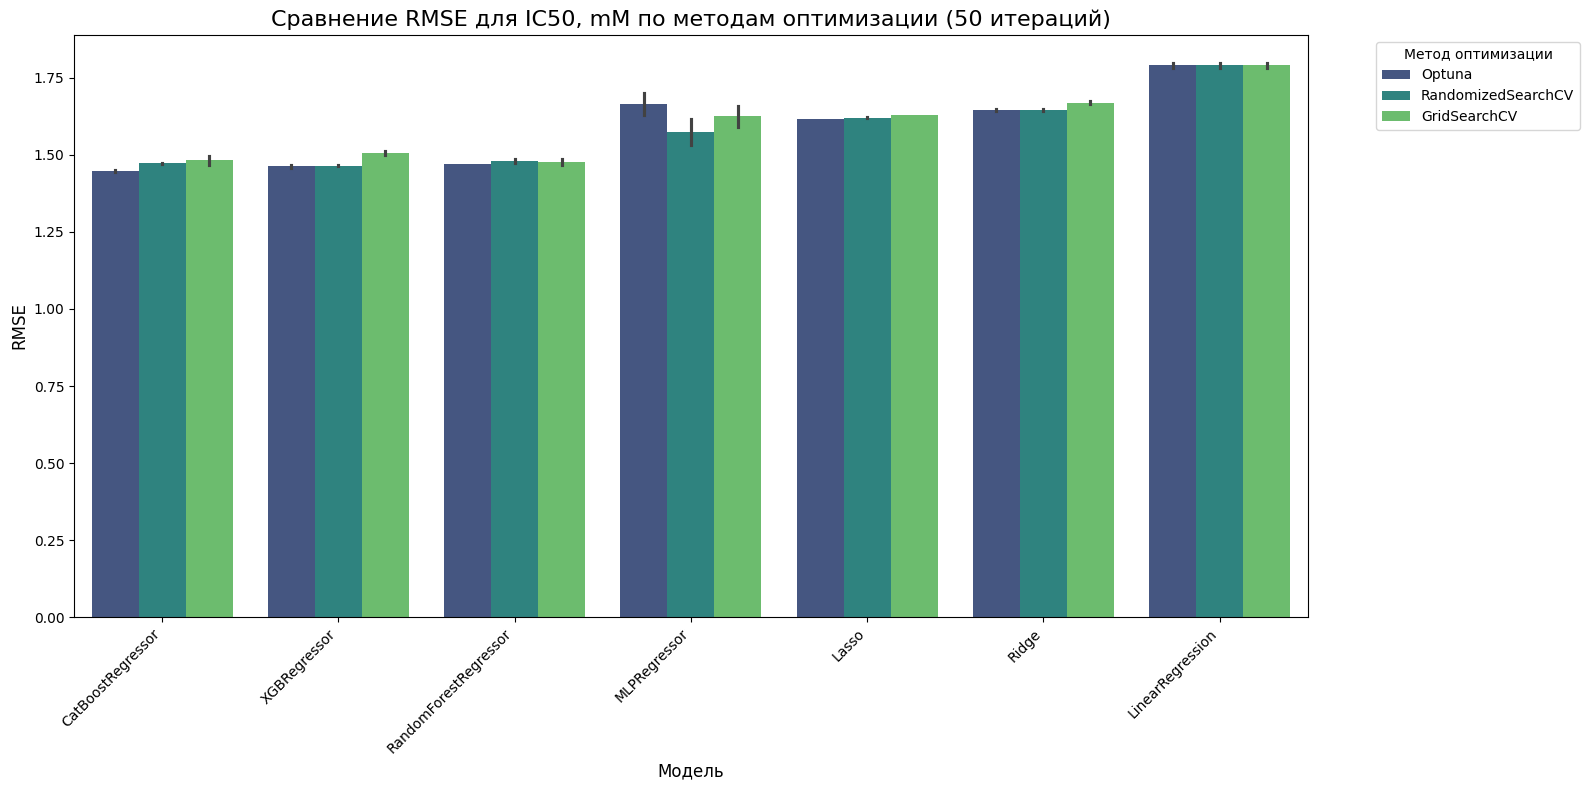

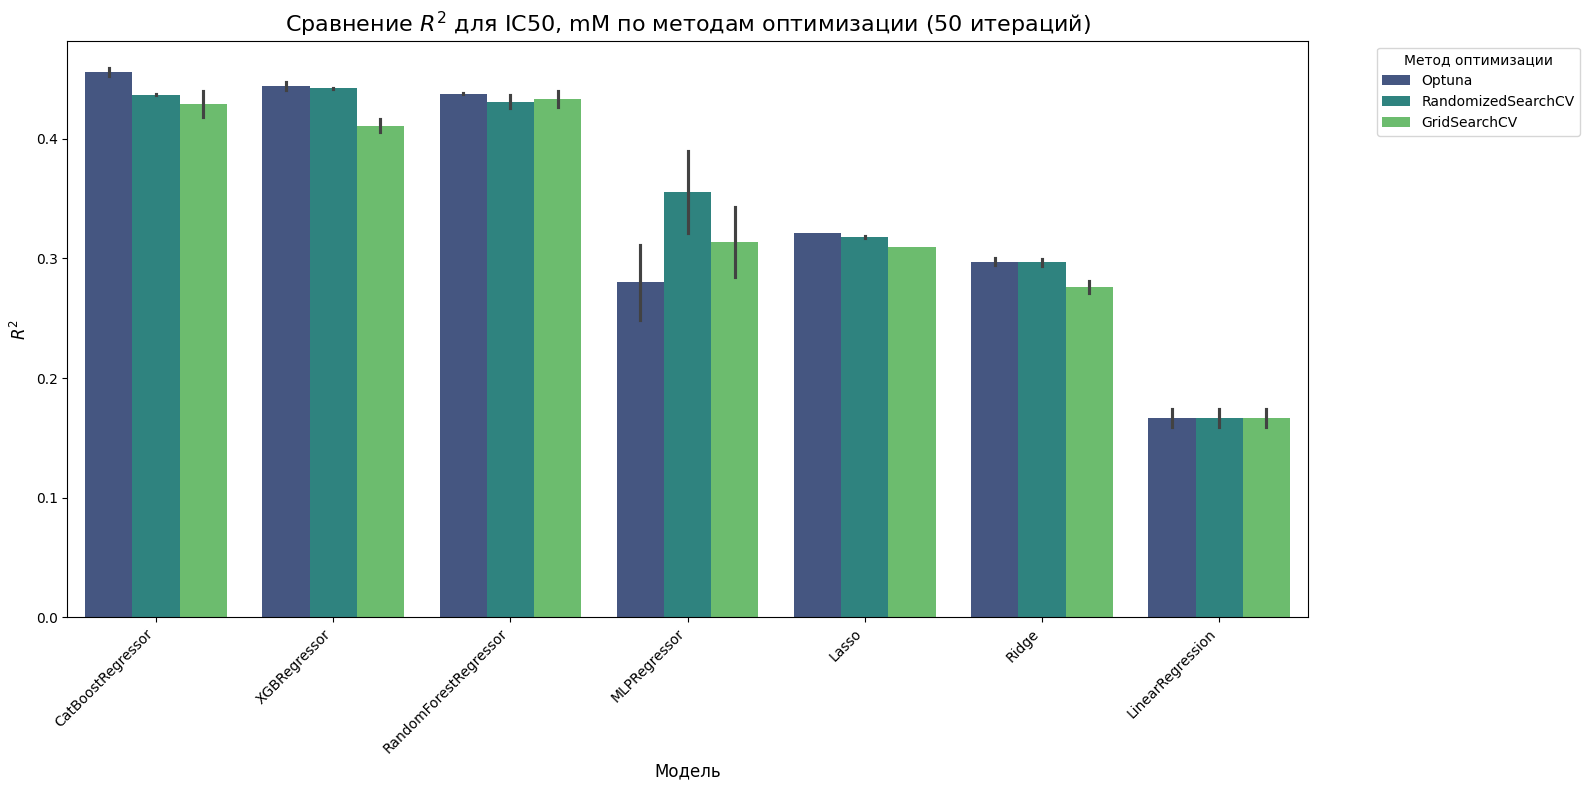

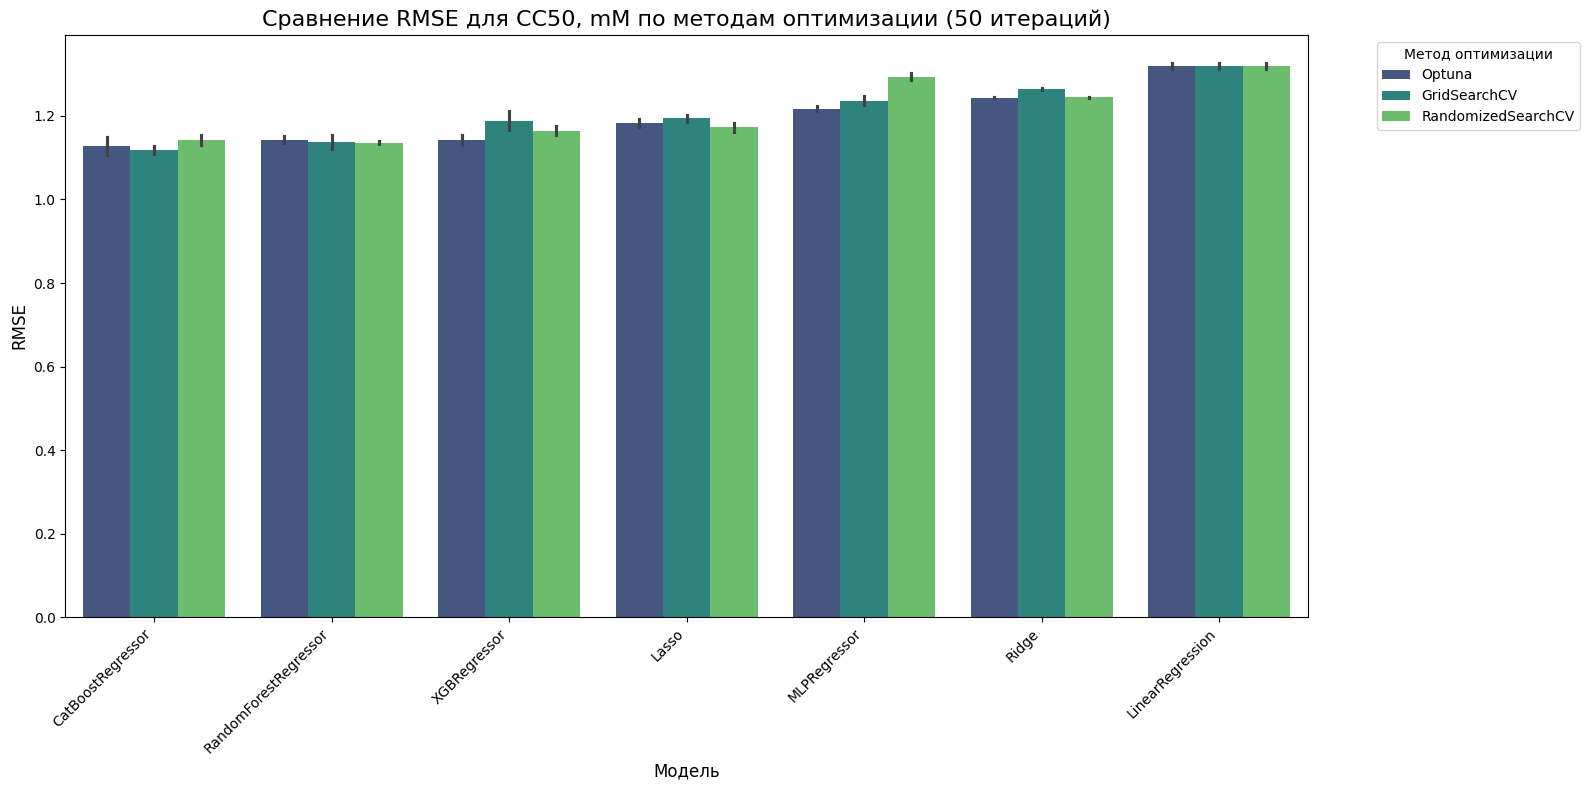

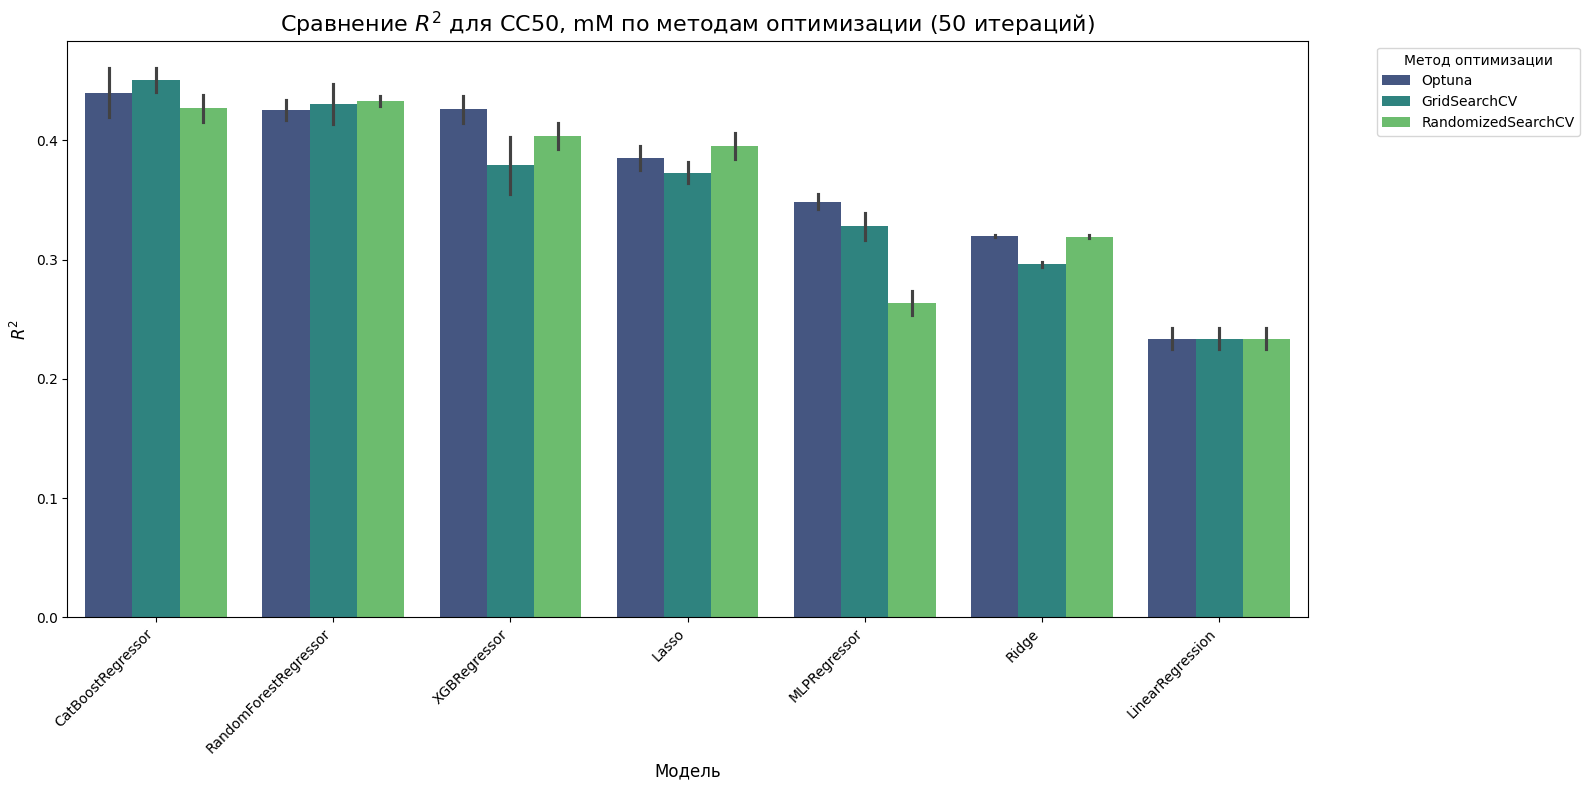

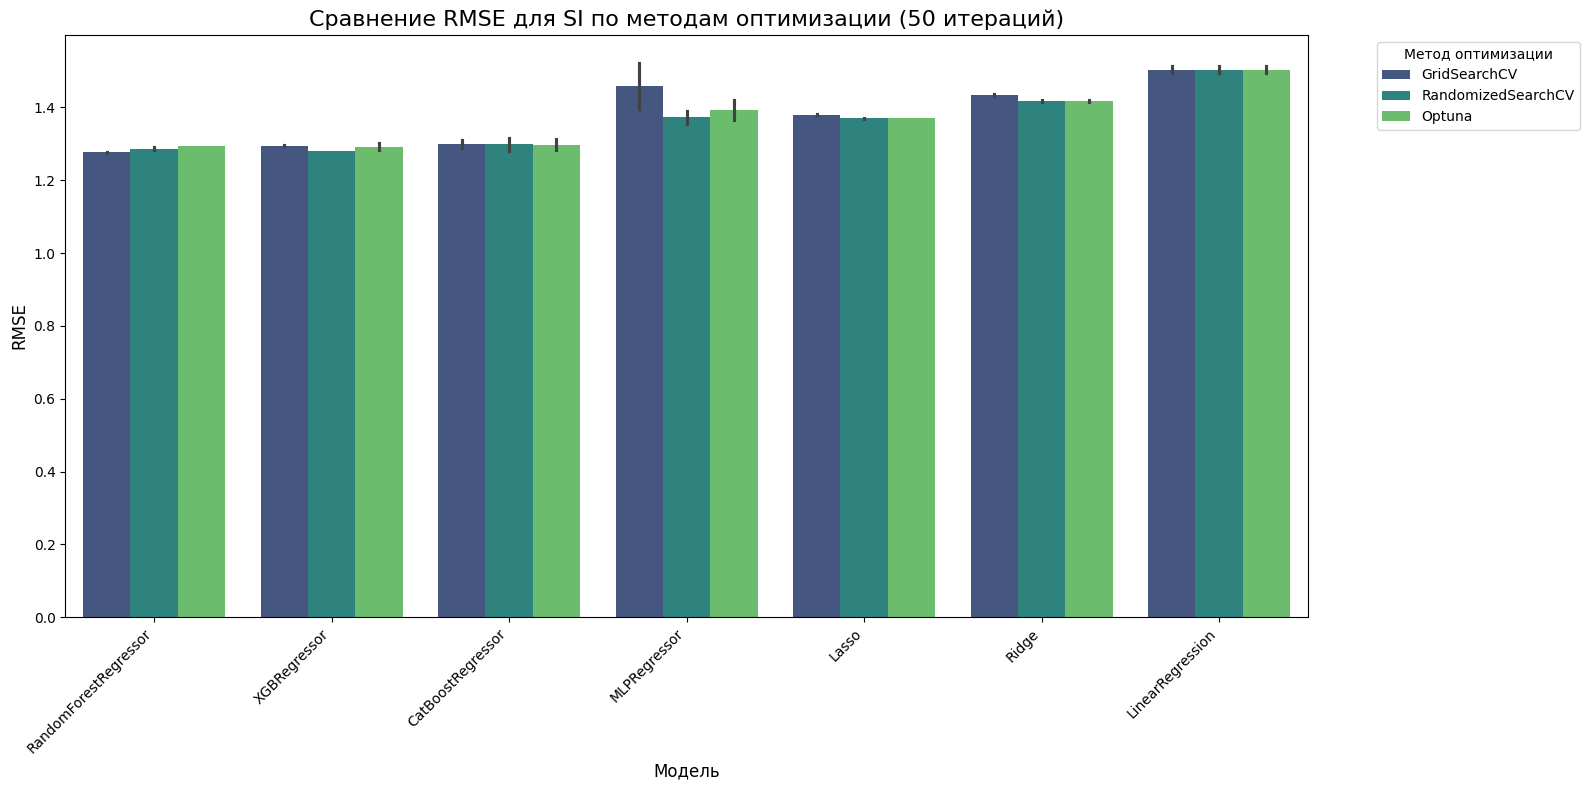

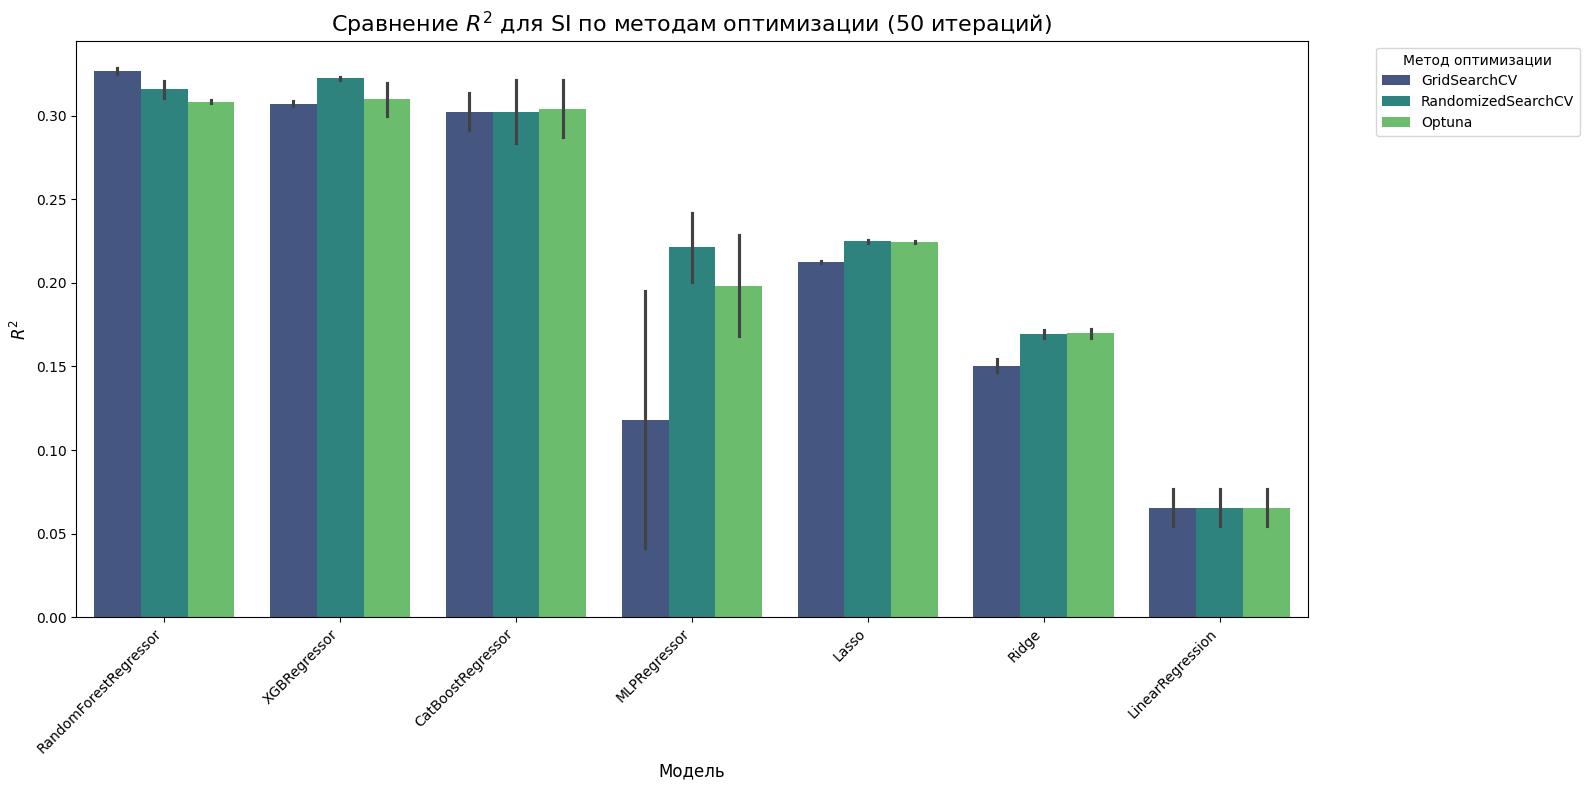

In [ ]:
# --- Сохранение и вывод результатов ---
output_file = Path('model_results_all_optimizers_50_iter.csv')

all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv(output_file, index=False)
print(f"\nРезультаты сохранены в: {output_file}")

print("\n--- Сводка результатов по методам оптимизации ---")

# Группируем результаты по оптимизатору, затем по целевой переменной и модели
for optimizer in optimizers:
    print(f"\n## Результаты {optimizer}:")
    subset_optimizer = all_results_df[all_results_df['optimizer'] == optimizer]
    # Сортируем внутри каждой группы оптимизатора
    print(subset_optimizer.sort_values(by=['target', 'rmse']).to_string())
    print("\n" + "-"*50 + "\n") # Разделитель

# Визуализация
for target in TARGETS:
    plt.figure(figsize=(16, 8))
    subset = all_results_df[all_results_df['target'] == target].sort_values(by='rmse')
    sns.barplot(x='model', y='rmse', hue='optimizer', data=subset, palette='viridis')
    plt.title(f'Сравнение RMSE для {target} по методам оптимизации (50 итераций)', fontsize=16)
    plt.ylabel('RMSE', fontsize=12)
    plt.xlabel('Модель', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Метод оптимизации', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 8))
    sns.barplot(x='model', y='r2', hue='optimizer', data=subset, palette='viridis')
    plt.title(f'Сравнение $R^2$ для {target} по методам оптимизации (50 итераций)', fontsize=16)
    plt.ylabel('$R^2$', fontsize=12)
    plt.xlabel('Модель', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Метод оптимизации', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Строим графики по лучшим параметрам моделей...

Графики параметров для CatBoostRegressor:


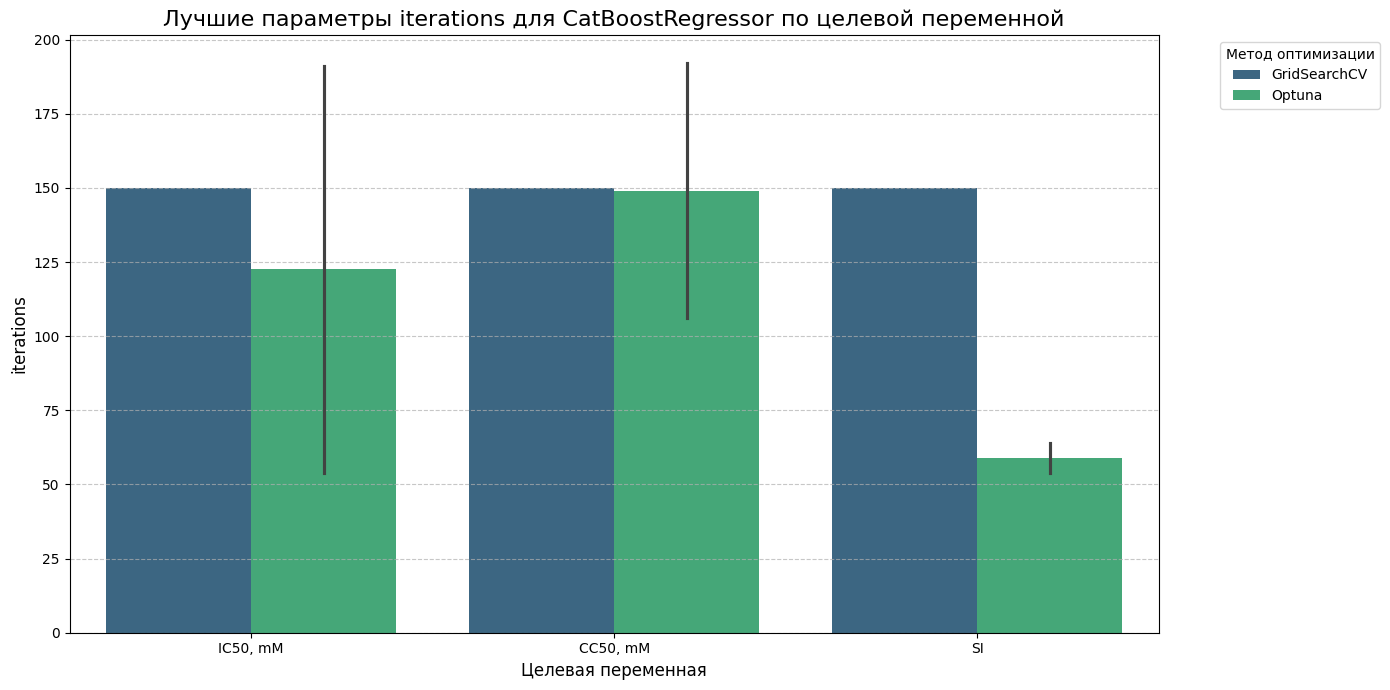

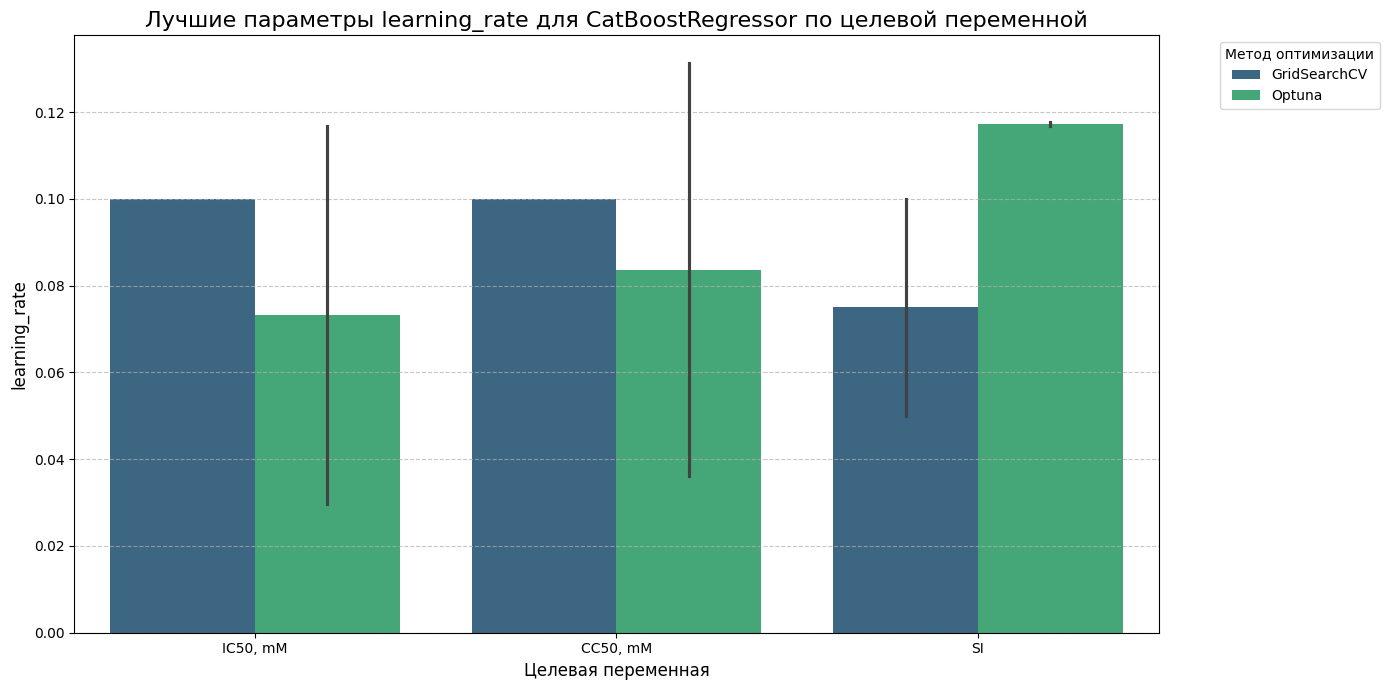

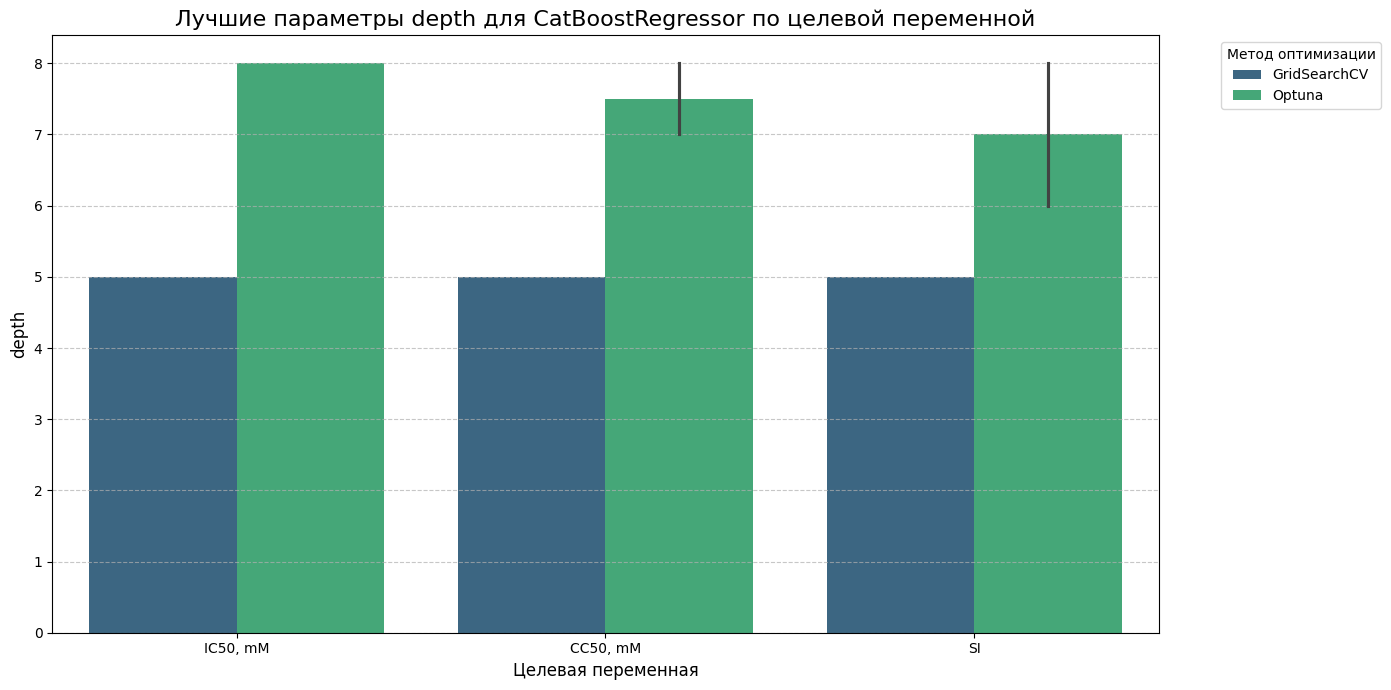

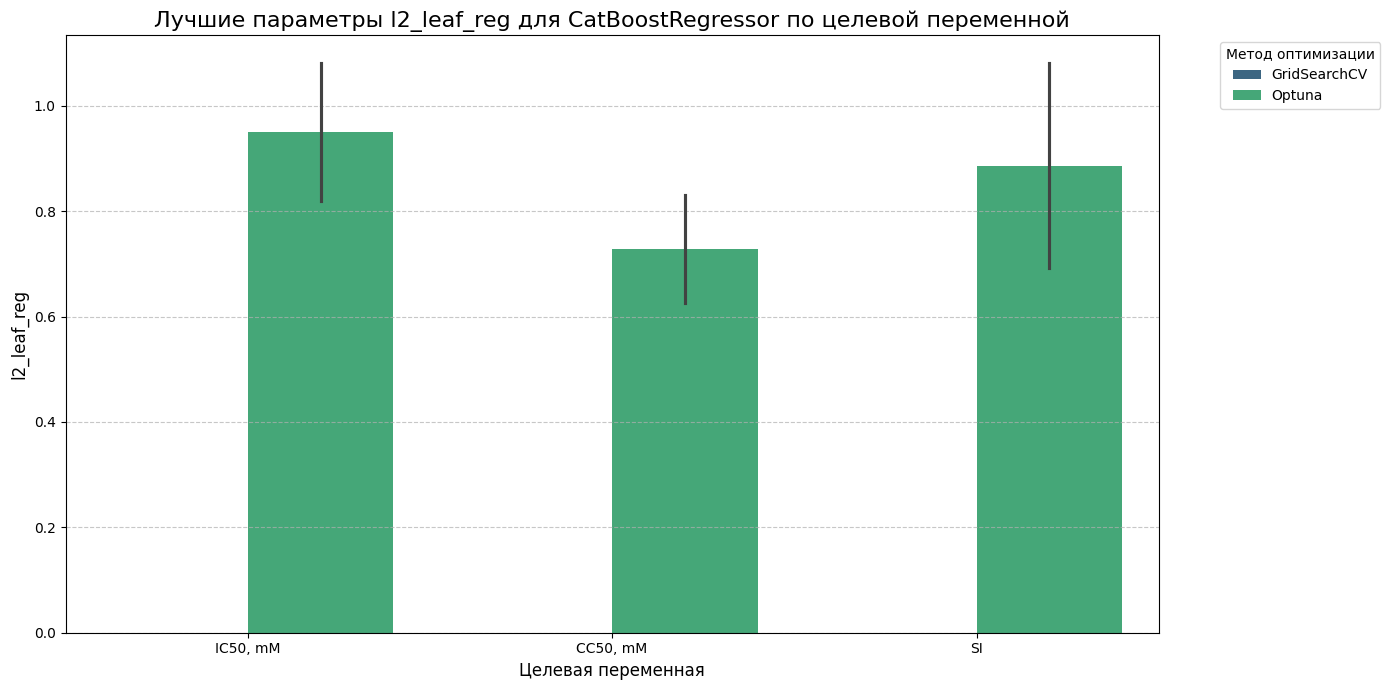


Графики параметров для XGBRegressor:


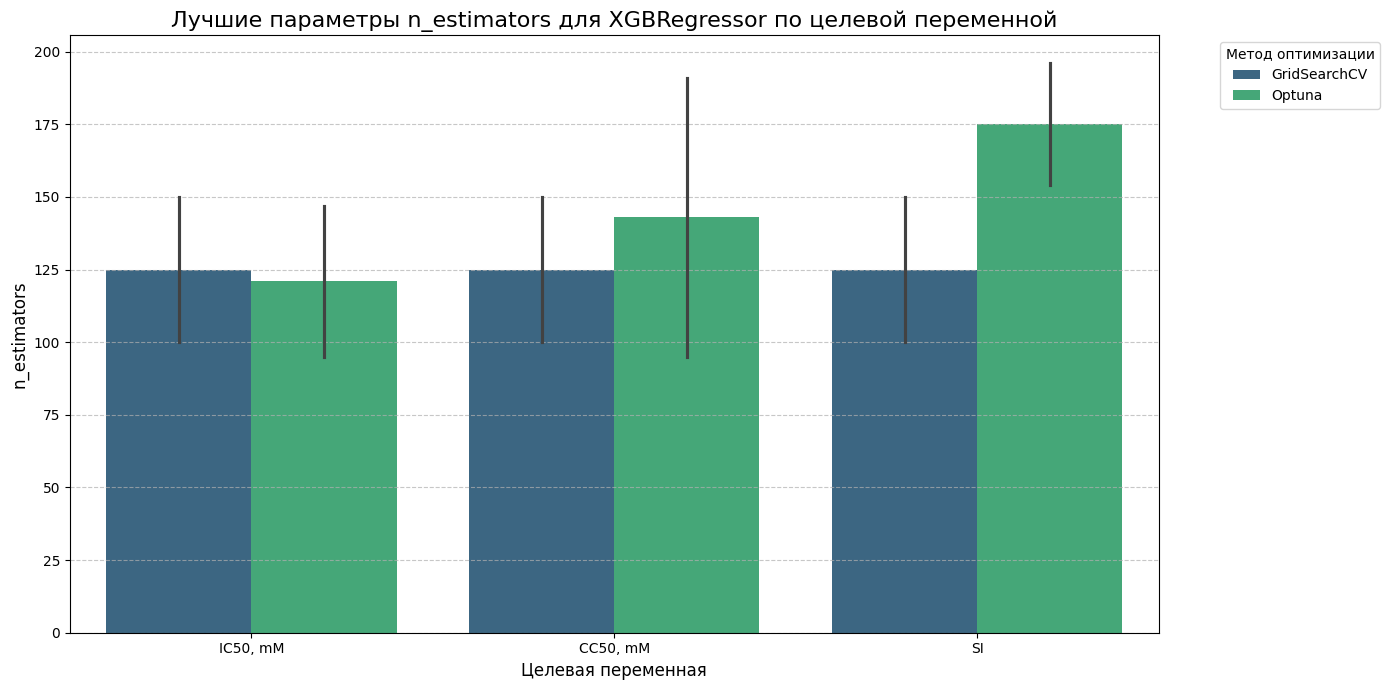

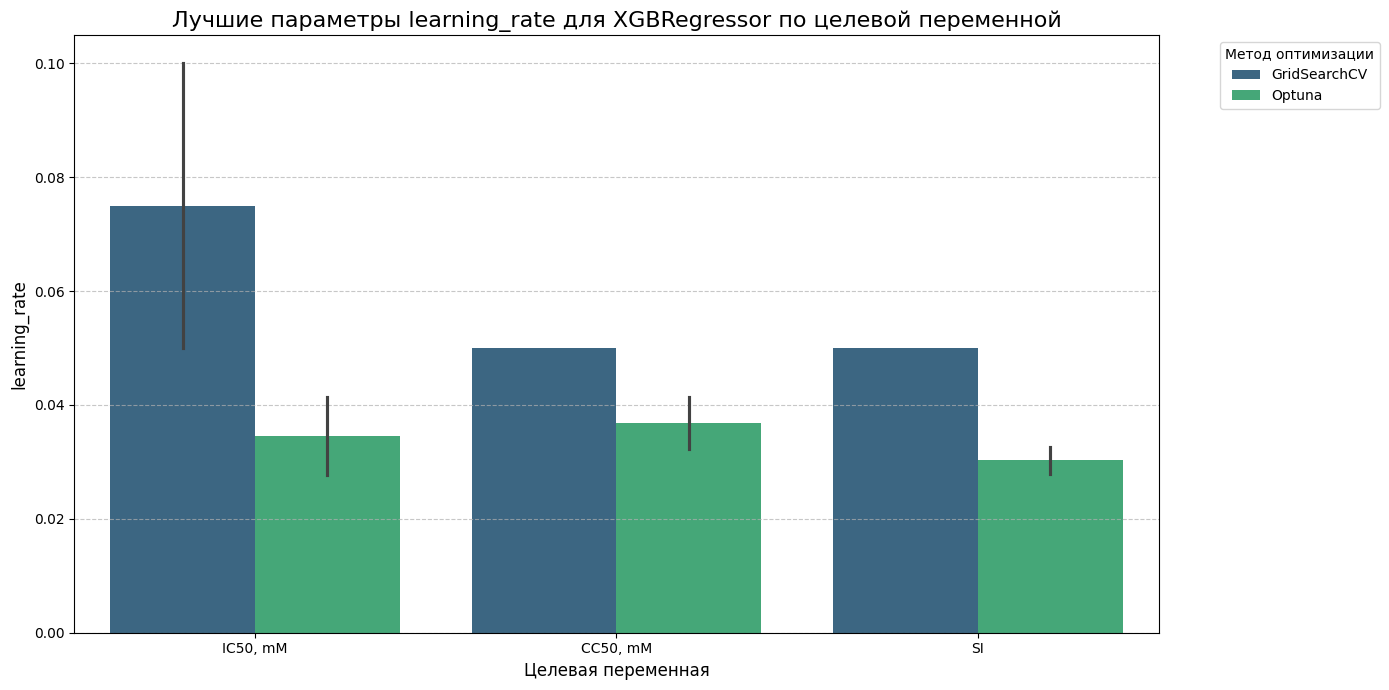

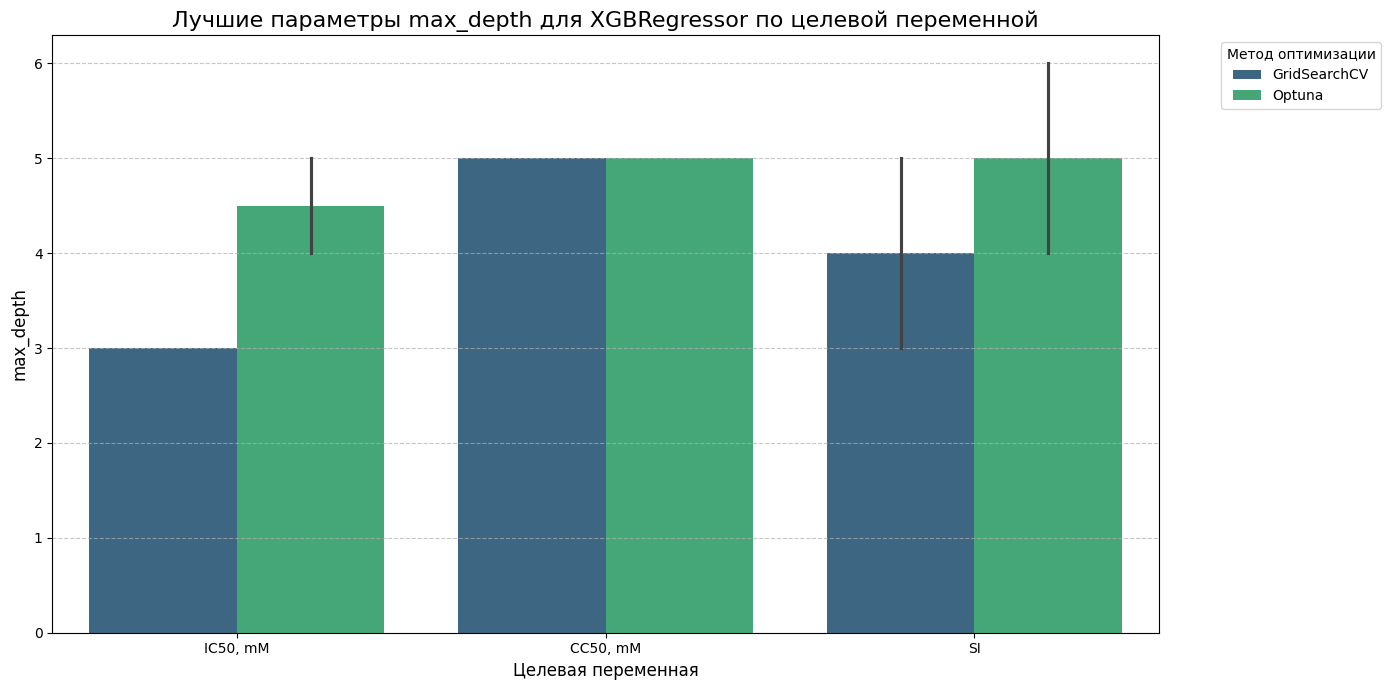

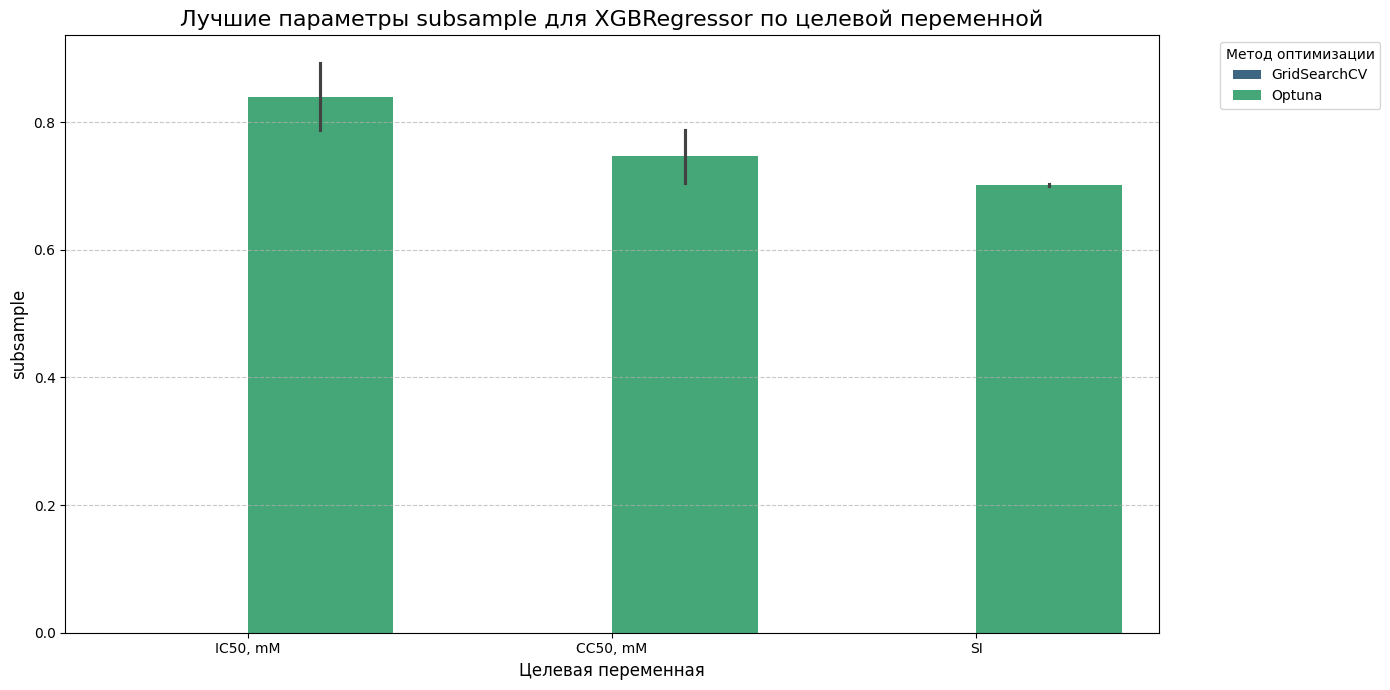


Графики параметров для RandomForestRegressor:


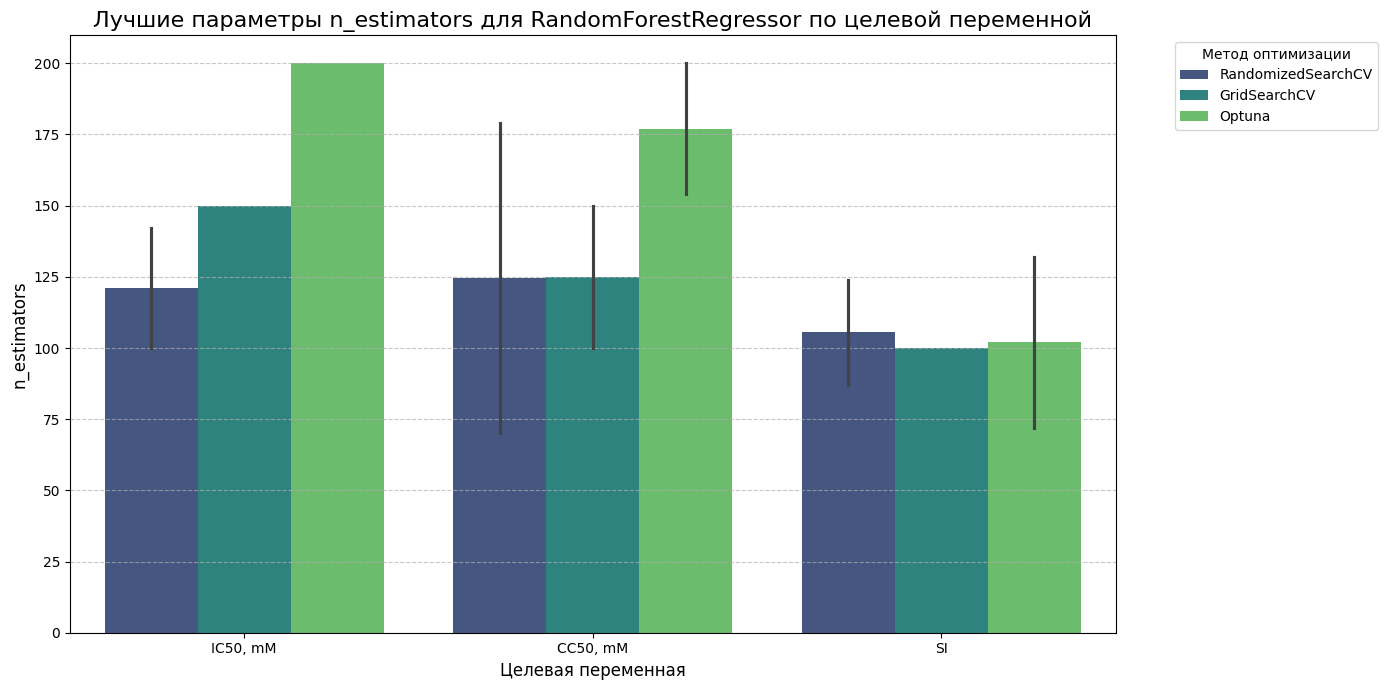

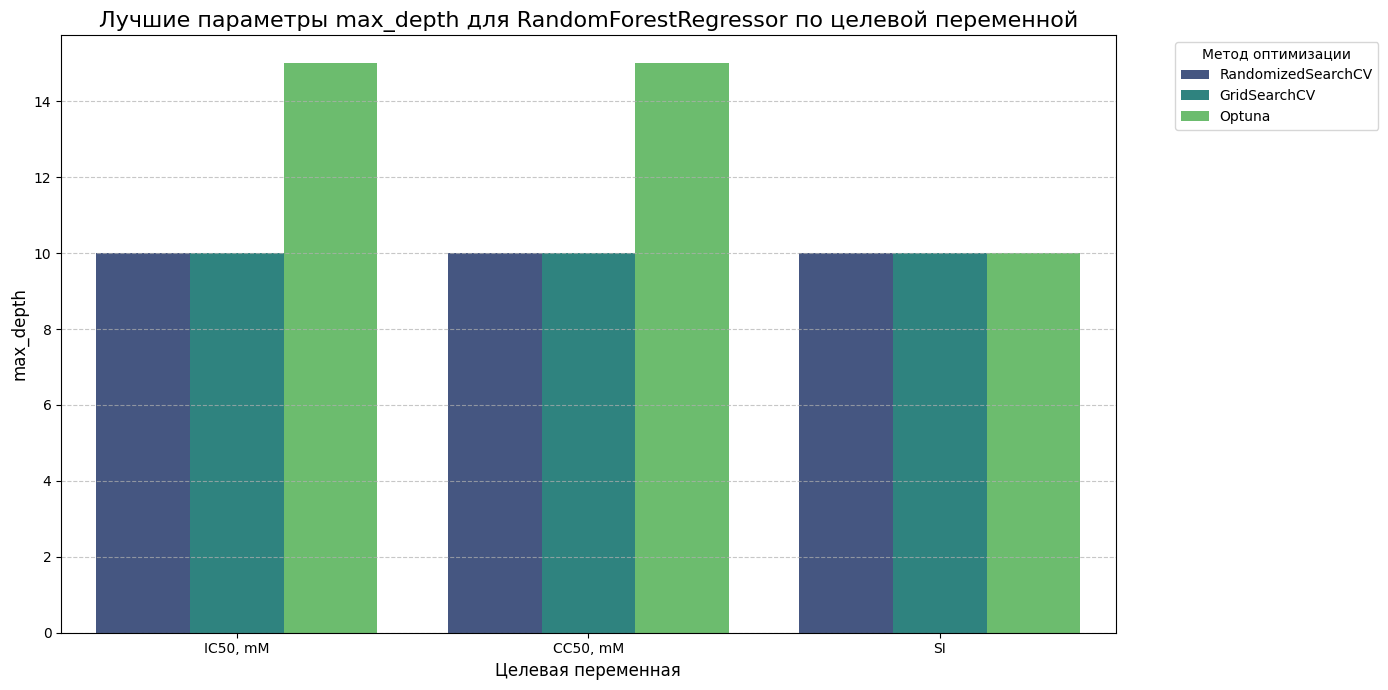

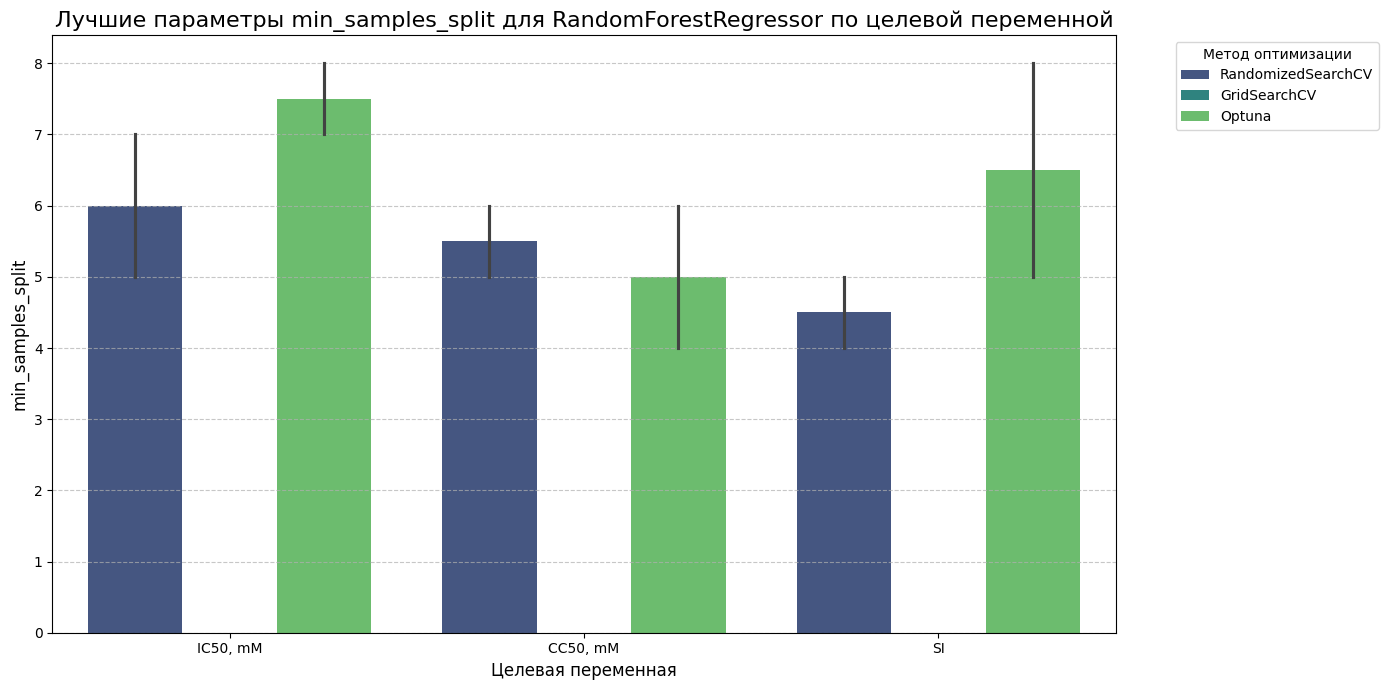


Графики параметров для MLPRegressor:


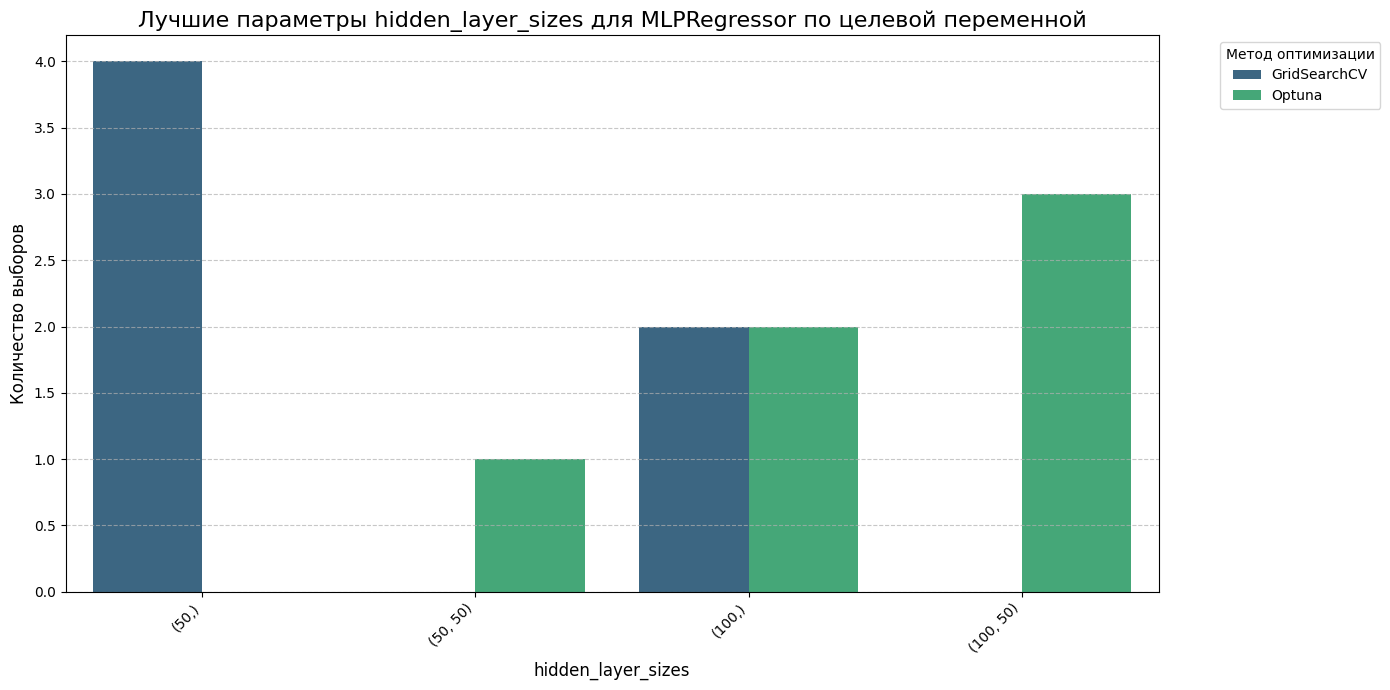

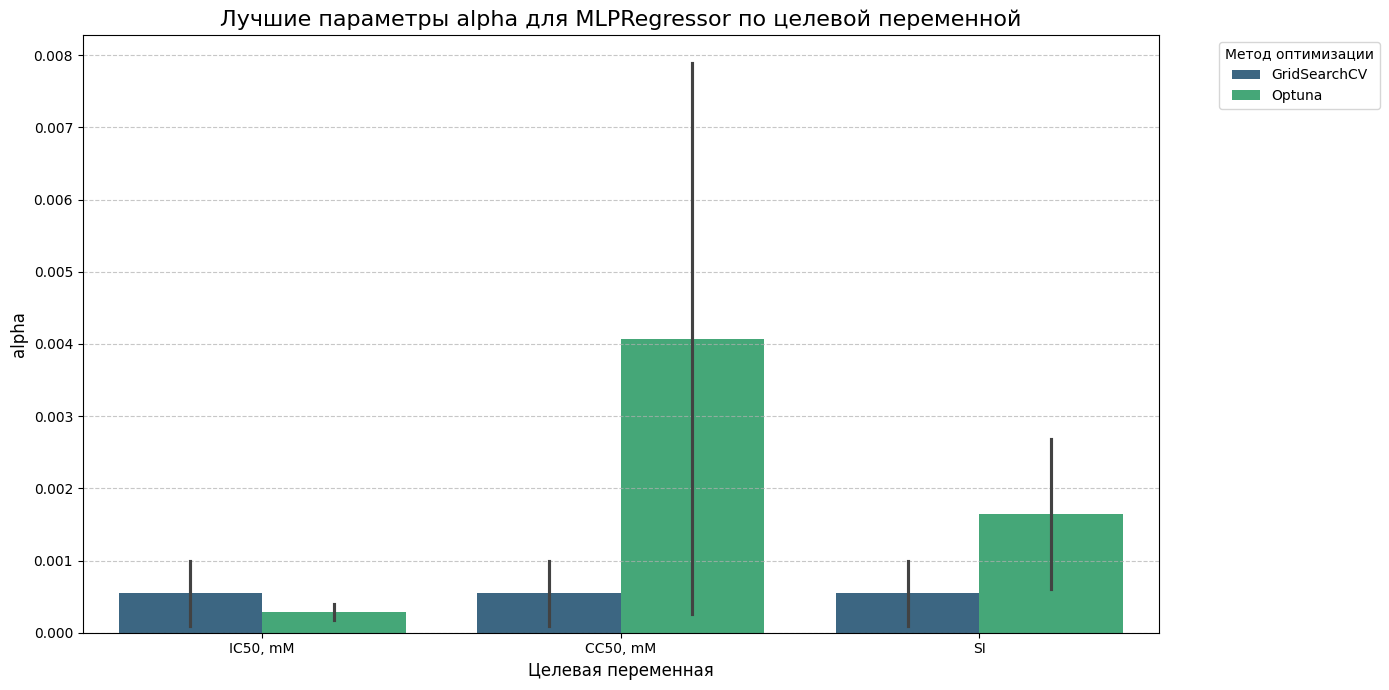

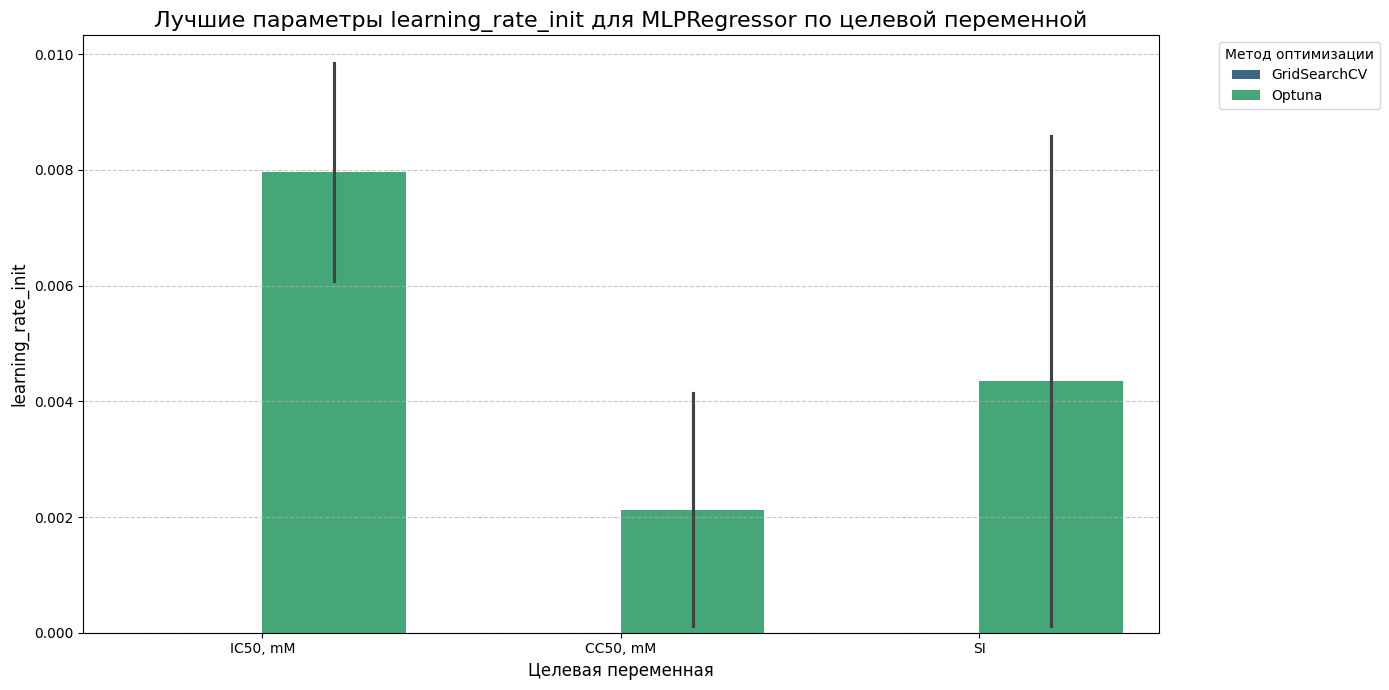


Построение графиков параметров завершено.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
import ast # Импортируем ast для literal_eval


output_file = Path('model_results_all_optimizers_50_iter.csv')
all_results_df = pd.read_csv(output_file)

# Целевые переменные
TARGETS = ['IC50,_mM', 'CC50,_mM', 'SI']

print("Строим графики по лучшим параметрам моделей...")

# --- Функция для извлечения параметров и построения графиков ---
def plot_best_params(df_results, model_name, param_names, title_prefix="Лучшие параметры"):
    """
    Строит графики лучших параметров для заданной модели.

    Args:
        df_results (pd.DataFrame): DataFrame с результатами моделей.
        model_name (str): Имя модели для фильтрации.
        param_names (list): Список имен параметров для отображения.
        title_prefix (str): Префикс для заголовка графика.
    """
    model_df = df_results[df_results['model'] == model_name].copy()

    if model_df.empty:
        print(f"Нет данных для модели: {model_name}. Пропуск графиков параметров.")
        return

    # Используем функцию для безопасного преобразования строки в словарь
    def safe_literal_eval(x):
        if pd.isna(x): # Проверяем на NaN
            return {}
        if isinstance(x, dict): # Если это уже словарь (возможно, после повторного запуска или сохранения)
            return x
        try:
            # ast.literal_eval может вызывать ошибку для пустых строк или некорректных форматов
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            # Если не удалось распарсить, возвращаем пустой словарь
            return {}

    model_df['parsed_params'] = model_df['best_params'].apply(safe_literal_eval)

    # Создаем отдельные столбцы для каждого параметра
    for param_name in param_names:
        # Получаем значение параметра, если оно есть, иначе NaN
        model_df[param_name] = model_df['parsed_params'].apply(lambda x: x.get(param_name, np.nan))

    # Удаляем строки, где все нужные параметры NaN (например, для LinearRegression, если мы случайно ее включили)
    # Примечание: Убедитесь, что список param_names действительно содержит параметры, которые могут отсутствовать
    # для некоторых строк (например, если оптимизатор не нашел параметры или модель их не имеет)
    model_df.dropna(subset=[p for p in param_names if p in model_df.columns], how='all', inplace=True)

    if model_df.empty:
        print(f"Нет действительных параметров для построения графиков для модели: {model_name}. Пропуск.")
        return

    print(f"\nГрафики параметров для {model_name}:")
    for param in param_names:
        # Дополнительная проверка, что столбец существует и не пуст
        if param in model_df.columns and not model_df[param].isnull().all():
            # Обработка 'hidden_layer_sizes' для MLPRegressor, чтобы barplot мог работать с числами
            if param == 'hidden_layer_sizes':
                # Преобразуем кортежи в строки для оси X, чтобы их можно было сравнивать как категории
                # И создаем уникальный числовой ID для каждого кортежа, чтобы ось Y была числовой для barplot
                # Или, что более наглядно, просто отображаем их как категории на оси X
                # Для barplot, если Y-ось числовая, а X-ось категориальная, то 'hidden_layer_sizes' должен быть на X
                temp_df = model_df.dropna(subset=[param]).copy()
                temp_df[param + '_str'] = temp_df[param].astype(str) # Преобразуем в строку для оси X

                plt.figure(figsize=(14, 7))
                sns.countplot(data=temp_df, x=param + '_str', hue='optimizer', palette='viridis')
                plt.title(f'{title_prefix} {param} для {model_name} по целевой переменной', fontsize=16)
                plt.ylabel('Количество выборов', fontsize=12) # Это счетчик для countplot
                plt.xlabel(param, fontsize=12)
                plt.xticks(rotation=45, ha='right', fontsize=10)
                plt.yticks(fontsize=10)
                plt.legend(title='Метод оптимизации', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()

            else: # Для числовых параметров используем barplot
                plt.figure(figsize=(14, 7))
                sns.barplot(data=model_df, x='target', y=param, hue='optimizer', palette='viridis')
                plt.title(f'{title_prefix} {param} для {model_name} по целевой переменной', fontsize=16)
                plt.ylabel(param, fontsize=12)
                plt.xlabel('Целевая переменная', fontsize=12)
                plt.xticks(rotation=0, ha='center', fontsize=10)
                plt.yticks(fontsize=10)
                plt.legend(title='Метод оптимизации', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
        else:
            print(f"Параметр '{param}' не найден или все значения NaN для модели {model_name}.")

# --- Вызовы функции для конкретных моделей и их параметров ---

# CatBoostRegressor
plot_best_params(all_results_df, "CatBoostRegressor", ['iterations', 'learning_rate', 'depth', 'l2_leaf_reg'])

# XGBRegressor
plot_best_params(all_results_df, "XGBRegressor", ['n_estimators', 'learning_rate', 'max_depth', 'subsample'])

# RandomForestRegressor
plot_best_params(all_results_df, "RandomForestRegressor", ['n_estimators', 'max_depth', 'min_samples_split'])

# MLPRegressor
# Для MLPRegressor 'hidden_layer_sizes' лучше всего визуализировать с помощью countplot,
# а остальные параметры - barplot
plot_best_params(all_results_df, "MLPRegressor", ['hidden_layer_sizes', 'alpha', 'learning_rate_init'])

print("\nПостроение графиков параметров завершено.")

In [ ]:
import pandas as pd
from pathlib import Path
import ast # Нужен для безопасного преобразования строк в словари

# Предполагается, что all_results_df уже загружен или создан
output_file = Path('model_results_all_optimizers_50_iter.csv')
all_results_df = pd.read_csv(output_file)

# Функция для безопасного преобразования строки в словарь, которую мы уже использовали
def safe_literal_eval(x):
    if pd.isna(x):
        return {}
    if isinstance(x, dict):
        return x
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return {}

# Применяем функцию к столбцу 'best_params'
all_results_df['parsed_best_params'] = all_results_df['best_params'].apply(safe_literal_eval)

# Выбираем столбцы для сводной таблицы
# Включаем ключевые метрики и разобранные параметры
summary_columns = ['model', 'optimizer', 'target', 'rmse', 'r2', 'parsed_best_params']
summary_df = all_results_df[summary_columns].copy()

# Переименовываем 'parsed_best_params' в 'Best Parameters' для лучшей читаемости
summary_df.rename(columns={'parsed_best_params': 'Best Parameters'}, inplace=True)

# Сортируем для лучшей читаемости: сначала по целевой переменной, затем по модели, затем по оптимизатору
summary_df_sorted = summary_df.sort_values(by=['target', 'model', 'optimizer']).reset_index(drop=True)

print("--- Сводная таблица лучших параметров ---")
print(summary_df_sorted.to_string()) # Используем to_string(), чтобы избежать усечения вывода
print("\n--- Конец сводной таблицы ---")

--- Сводная таблица лучших параметров ---
                     model           optimizer    target      rmse        r2                                                                                                  Best Parameters
0        CatBoostRegressor        GridSearchCV  CC50, mM  1.128095  0.440446                                                            {'depth': 5, 'iterations': 150, 'learning_rate': 0.1}
1        CatBoostRegressor        GridSearchCV  CC50, mM  1.107857  0.460343                                                            {'depth': 5, 'iterations': 150, 'learning_rate': 0.1}
2        CatBoostRegressor              Optuna  CC50, mM  1.107670  0.460525          {'iterations': 192, 'learning_rate': 0.0360309842192462, 'depth': 8, 'l2_leaf_reg': 0.8306050731972209}
3        CatBoostRegressor              Optuna  CC50, mM  1.149253  0.419260         {'iterations': 106, 'learning_rate': 0.13125830316209655, 'depth': 7, 'l2_leaf_reg': 0.6251373574521749}
4       